
   ###  2D Stochastic Gaussian Simulation in Python for Engineers and Geoscientists 

### with GSLIB's SGSIM Program Converted to Python

#### Michael Pyrcz, Associate Professor, University of Texas at Austin 


#### Contacts: [Twitter/@GeostatsGuy](https://twitter.com/geostatsguy) | [GitHub/GeostatsGuy](https://github.com/GeostatsGuy) | [www.michaelpyrcz.com](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446)

This is a tutorial for / demonstration of **Sequential Gaussian Simulation in Python with GSLIB's SGSIM program translated to Python from the original FORTRAN GSLIB: Geostatistical Library methods** (Deutsch and Journel, 1997). 

### PGE 383 Exercise: Methods for Spatial Simulation with GeostatsPy

Here's a simple workflow for spatial simulation with SGSIM. This method is ciritical for:

* Building spatial models that honor the univariate and spatial distribution of the property of interest 

First let's explain the concept of spatial simulation.

#### Spatial Simulation




#### Objective 

In the PGE 383: Stochastic Subsurface Modeling class I want to provide hands-on experience with building subsurface modeling workflows. Python provides an excellent vehicle to accomplish this. I have coded a package called GeostatsPy with GSLIB: Geostatistical Library (Deutsch and Journel, 1998) functionality that provides basic building blocks for building subsurface modeling workflows. 

The objective is to remove the hurdles of subsurface modeling workflow construction by providing building blocks and sufficient examples. This is not a coding class per se, but we need the ability to 'script' workflows working with numerical methods.    

#### Getting Started

Here's the steps to get setup in Python with the GeostatsPy package:

1. Install Anaconda 3 on your machine (https://www.anaconda.com/download/). 
2. From Anaconda Navigator (within Anaconda3 group), go to the environment tab, click on base (root) green arrow and open a terminal. 
3. In the terminal type: pip install geostatspy. 
4. Open Jupyter and in the top block get started by copy and pasting the code block below from this Jupyter Notebook to start using the geostatspy functionality. 

You will need to copy the data file to your working directory.  They are available here:

* Tabular data - sample_data_MV_biased.csv available at https://git.io/fhgu0.

There are exampled below with these functions. You can go here to see a list of the available functions, https://git.io/fh4eX, other example workflows and source code. 

#### Load the required libraries

The following code loads the required libraries.

In [6]:
import os                                                 # to set current working directory 
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames
import matplotlib.pyplot as plt                           # plotting
import geostatspy.GSLIB as GSLIB

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Load the Required Libraries

The following code loads the required libraries.

In [368]:
"""
This file includes the reimplementations of GSLIB functionality in Python. While
this code will not be as well-tested and robust as the original GSLIB, it does
provide the opportunity to build 2D spatial modeling projects in Python without
the need to rely on compiled Fortran code from GSLIB. If you want to use the
GSLIB compiled code called from Python workflows use the functions available
with geostatspy.GSLIB.
This file includes the (1) GSLIB subroutines (converted to Python), followed by
the (2) functions: declus, gam, gamv, nscore, kb2d (more added all the time)
Note: some GSLIB subroutines are not included as they were replaced by available
NumPy and SciPy functionality or they were not required as we don't have to deal
with graphics and files in the same manner as GSLIB.
The original GSLIB code is from GSLIB: Geostatistical Library by Deutsch and
Journel, 1998. The reimplementation is by Michael Pyrcz, Associate Professor,
the University of Texas at Austin.
"""

import math  # for trig functions etc.
from bisect import bisect  # for maintaining array elements sorted

import numpy as np  # for ndarrays
import numpy.linalg as linalg  # for linear algebra
import scipy.spatial as sp  # for fast nearest neighbor search
from numba import jit  # for numerical speed up
from statsmodels.stats.weightstats import DescrStatsW

def backtr(df,vcol,vr,vrg,zmin,zmax,ltail,ltpar,utail,utpar):   
    """Back transform an entire DataFrame column with a provided transformation table and tail extrapolation.
    :param df: the source DataFrame
    :param vcol: the column with the variable to transfrom
    :param vr: the transformation table, 1D ndarray with the original values
    :param vrg: the transformation table, 1D ndarray with the trasnformed variable
    :param zmin: lower trimming limits
    :param zmax: upper trimming limits
    :param ltail: lower tail value
    :param ltpar: lower tail extrapolation parameter
    :param utail: upper tail value
    :param utpar: upper tail extrapolation parameter
    :return: TODO
    """    
    
    EPSLON=1.0e-20
    nd = len(df); nt = len(vr) # number of data to transform and number of data in table
    backtr = np.zeros(nd)
    vrgs = df[vcol].values
    # Value in the lower tail?    1=linear, 2=power, (3 and 4 are invalid):
    for id in range(0,nd):
        if vrgs[id] <= vrg[0]:
            backtr[id] = vr[0]
            cdflo  = gcum(vrg[0])
            cdfbt  = gcum(vrgs[id])
            if ltail == 1:
                backtr[id] = powint(0.0,cdflo,zmin,vr[0],cdfbt,1.0)
            elif ltail == 2:
                cpow   = 1.0 / ltpar
                backtr[id] = powint(0.0,cdflo,zmin,vr[0],cdfbt,cpow)
        # Value in the upper tail?     1=linear, 2=power, 4=hyperbolic:
        elif vrgs[id] >= vrg[nt-1]:
            backtr[id] = vr[nt-1]
            cdfhi  = gcum(vrg[nt-1])
            cdfbt  = gcum(vrgs[id])
            if utail == 1:
                backtr[id] = powint(cdfhi,1.0,vr[nt-1],zmax,cdfbt,1.0)
            elif utail == 2: 
                cpow   = 1.0 / utpar
                backtr[id] = powint(cdfhi,1.0,vr[nt-1],zmax,cdfbt,cpow)
            elif utail == 4:
                plambda = (vr[nt-1]**utpar)*(1.0-gcum(vrg[nt-1]))
                backtr[id] = (plambda/(1.0-gcum(vrgs)))**(1.0/utpar)
        else:
            # Value within the transformation table:
            j = locate(vrg,1,nt,vrgs[id])
            j = max(min((nt-2),j),1)
            backtr[id] = powint(vrg[j],vrg[j+1],vr[j],vr[j+1],vrgs[id],1.0)
    return backtr

def backtr_value(vrgs,vr,vrg,zmin,zmax,ltail,ltpar,utail,utpar): 
    """Back transform a single value with a provided transformation table and tail extrapolation.
    :param vrgs: value to transform
    :param vr: the transformation table, 1D ndarray with the original values
    :param vrg: the transformation table, 1D ndarray with the trasnformed variable
    :param zmin: lower trimming limits
    :param zmax: upper trimming limits
    :param ltail: lower tail value
    :param ltpar: lower tail extrapolation parameter
    :param utail: upper tail value
    :param utpar: upper tail extrapolation parameter
    :return: TODO
    """  
    EPSLON=1.0e-20
    nt = len(vr) # number of data to transform 
# Value in the lower tail?    1=linear, 2=power, (3 and 4 are invalid):
    if vrgs <= vrg[0]:
        backtr = vr[0]
        cdflo  = gcum(vrg[0])
        cdfbt  = gcum(vrgs)
        if ltail == 1:
            backtr = dpowint(0.0,cdflo,zmin,vr[0],cdfbt,1.0)
        elif ltail == 2:
            cpow   = 1.0 / ltpar
            backtr = dpowint(0.0,cdflo,zmin,vr[0],cdfbt,cpow)
# Value in the upper tail?     1=linear, 2=power, 4=hyperbolic:
    elif vrgs >= vrg[nt-1]:
        backtr = vr[nt-1]
        cdfhi  = gcum(vrg[nt-1])
        cdfbt  = gcum(vrgs)
        if utail == 1:
            backtr = dpowint(cdfhi,1.0,vr[nt-1],zmax,cdfbt,1.0)
        elif utail == 2: 
            cpow   = 1.0 / utpar
            backtr = dpowint(cdfhi,1.0,vr[nt-1],zmax,cdfbt,cpow)
        elif utail == 4:
            plambda = (vr[nt-1]**utpar)*(1.0-gcum(vrg[nt-1]))
            backtr = (plambda/(1.0-gcum(vrgs)))**(1.0/utpar)
    else:
# Value within the transformation table:
        j = dlocate(vrg,1,nt,vrgs)
        j = max(min((nt-2),j),1)
        backtr = dpowint(vrg[j],vrg[j+1],vr[j],vr[j+1],vrgs,1.0)
    return backtr

def gcum(x):
    """Calculate the cumulative probability of the standard normal distribution.
    :param x: the value from the standard normal distribution 
    :return: TODO
    """    
    
    z = x
    if z < 0: 
        z = -z
    t  = 1./(1.+ 0.2316419*z)
    gcum = t*(0.31938153   + t*(-0.356563782 + t*(1.781477937 + t*(-1.821255978 + t*1.330274429))))
    e2   = 0.
    #  6 standard deviations out gets treated as infinity:
    if z <= 6.: 
        e2 = np.exp(-z*z/2.)*0.3989422803
    gcum = 1.0- e2 * gcum
    if x >= 0:
        return gcum
    gcum = 1.0 - gcum
    return gcum

def locate(xx,iis,iie,x):
    """Return value `j` such that `x` is between `xx[j]` and `xx[j+1]`, where
    `xx` is an array of length `n`, and `x` is a given value. `xx` must be
    monotonic, either increasing or decreasing (GSLIB version).
    :param xx: array
    :param iis: start point
    :param iie: end point
    :param x: given value
    :return: TODO
    """
    
    n = len(xx)
# Initialize lower and upper methods:
    if iis <= 0: 
        iis = 0
    if iie >= n:
        iie = n-1
    jl = iis-1
    ju = iie
    if xx[n-1] <= x:
        j = iie
        return j
# If we are not done then compute a midpoint:
    while (ju-jl) > 1: 
        jm = int((ju+jl)/2)
# Replace the lower or upper limit with the midpoint:
        if (xx[iie] > xx[iis]) == (x > xx[jm]):
            jl = jm
        else:
            ju = jm
# Return with the array index:
    j = jl
    return j

def dlocate(xx, iis, iie, x):
    """Return value `j` such that `x` is between `xx[j]` and `xx[j+1]`, where
    `xx` is an array of length `n`, and `x` is a given value. `xx` must be
    monotonic, either increasing or decreasing (updated with Python bisect)
    :param xx: array
    :param iis: start point
    :param iie: end point
    :param x: given value
    :return: TODO
    """
    n = len(xx)
    if iie <= iis:
        iis = 0
        iie = n - 1
    array = xx[iis: iie - 1]  # this is accounting for swith to 0,...,n-1 index
    j = bisect(array, x)
    return j

def powint(xlow,xhigh,ylow,yhigh,xval,power):
    """Power-based interpolator 
    :param xlow: x lower interval
    :param xhigh: x upper interval
    :param ylow: y lower interval
    :param yhigh: y upper interval
    :param xval: value on x
    :param power: power for interpolation
    :return: TODO
    """    
    EPSLON=1.0e-20
    if (xhigh-xlow) < EPSLON:
        powint = (yhigh+ylow)/2.0
    else:
        powint = ylow + (yhigh-ylow)*(((xval-xlow)/(xhigh-xlow))**power)
    return powint


def dsortem(ib, ie, a, iperm, b=0, c=0, d=0, e=0, f=0, g=0, h=0):
    """Sort array in ascending order.
    :param ib: start index
    :param ie: end index
    :param a: array
    :param iperm: 0 no other array is permuted.
                  1 array b is permuted according to array a.
                  2 arrays b, c are permuted.
                  3 arrays b, c, d are permuted.
                  4 arrays b, c, d, e are permuted.
                  5 arrays b, c, d, e, f are permuted.
                  6 arrays b, c, d, e, f, g are permuted.
                  7 arrays b, c, d, e, f, g, h are permuted.
                 >7 no other array is permuted.
    :param b: array to be permuted according to array a.
    :param c: array to be permuted according to array a.
    :param d: array to be permuted according to array a.
    :param e: array to be permuted according to array a.
    :param f: array to be permuted according to array a.
    :param g: array to be permuted according to array a.
    :param h: array to be permuted according to array a.
    :return: a: the array, a portion of which has been sorted.
             b, c, d, e, f, g, h: arrays permuted according to array a (see
             iperm)
    """
    a = a[ib:ie]
    inds = a.argsort()
    a = np.copy(a[inds])  # deepcopy forces pass to outside scope
    if iperm == 1:
        return a
    b_slice = b[ib:ie]
    b = b_slice[inds]
    if iperm == 2:
        return a, b
    c_slice = c[ib:ie]
    c = c_slice[inds]
    if iperm == 3:
        return a, b, c
    d_slice = d[ib:ie]
    d = d_slice[inds]
    if iperm == 4:
        return a, b, c, d
    e_slice = e[ib:ie]
    e = e_slice[inds]
    if iperm == 5:
        return a, b, c, d, e
    f_slice = f[ib:ie]
    f = f_slice[inds]
    if iperm == 6:
        return a, b, c, d, e, f
    g_slice = g[ib:ie]
    g = g_slice[inds]
    if iperm == 7:
        return a, b, c, d, e, f, g  # TODO: changed from 'a, b, c, d, e, f, h'
    h_slice = h[ib:ie]
    h = h_slice[inds]
    return a, b, c, d, e, f, g, h  # TODO: changed from 'a, b, c, d, e, f, h'

def gauinv(p):
    """Compute the inverse of the standard normal cumulative distribution
    function.
    :param p: cumulative probability value
    :return: TODO
    """
    lim = 1.0e-10
    p0 = -0.322_232_431_088
    p1 = -1.0
    p2 = -0.342_242_088_547
    p3 = -0.020_423_121_024_5
    p4 = -0.000_045_364_221_014_8
    q0 = 0.099_348_462_606_0
    q1 = 0.588_581_570_495
    q2 = 0.531_103_462_366
    q3 = 0.103_537_752_850
    q4 = 0.003_856_070_063_4

    # Check for an error situation
    if p < lim:
        xp = -1.0e10
        return xp
    if p > (1.0 - lim):
        xp = 1.0e10
        return xp

    # Get k for an error situation
    pp = p
    if p > 0.5:
        pp = 1 - pp
    xp = 0.0
    if p == 0.5:
        return xp

    # Approximate the function
    y = np.sqrt(np.log(1.0 / (pp * pp)))
    xp = float(
        y
        + ((((y * p4 + p3) * y + p2) * y + p1) * y + p0)
        / ((((y * q4 + q3) * y + q2) * y + q1) * y + q0)
    )
    if float(p) == float(pp):
        xp = -xp
    return xp


def gcum(x):
    """Evaluate the standard normal cdf given a normal deviate `x`. `gcum` is
    the area under a unit normal curve to the left of `x`. The results are
    accurate only to about 5 decimal places.
    :param x: TODO
    :return: TODO
    """
    z = x
    if z < 0:
        z = -z
    t = 1.0 / (1.0 + 0.231_641_9 * z)
    gcum_ = t * (
        0.319_381_53
        + t
        * (
            -0.356_563_782
            + t * (1.781_477_937 + t * (-1.821_255_978 + t * 1.330_274_429))
        )
    )
    e2 = 0.0
    # Standard deviations out gets treated as infinity
    if z <= 6:
        e2 = np.exp(-z * z / 2.0) * 0.398_942_280_3
    gcum_ = 1.0 - e2 * gcum_
    if x >= 0.0:
        return gcum_
    gcum_ = 1.0 - gcum_
    return gcum_


def dpowint(xlow, xhigh, ylow, yhigh, xval, pwr):
    """Power interpolate the value of `y` between (`xlow`, `ylow`) and
    (`xhigh`, `yhigh`) for a value of `x` and a power `pwr`.
    :param xlow: TODO
    :param xhigh: TODO
    :param ylow: TODO
    :param yhigh: TODO
    :param xval: TODO
    :param pwr: power
    :return: TODO
    """
    EPSLON = 1.0e-20
    if (xhigh - xlow) < EPSLON:
        dpowint_ = (yhigh + ylow) / 2.0
    else:
        dpowint_ = ylow + (yhigh - ylow) * (
            ((xval - xlow) / (xhigh - xlow)) ** pwr
        )
    return dpowint_

#@jit(nopython=True) # all NumPy array operations included in this function for precompile with NumBa
def setup_rotmat2(c0,nst,it,cc,ang):
    DTOR=3.14159265/180.0; EPSLON=0.000000; PI=3.141593
# The first time around, re-initialize the cosine matrix for the
# variogram structures:
    rotmat = np.zeros((4,nst))
    maxcov = c0
    for js in range(0,nst):
        azmuth = (90.0-ang[js])*DTOR
        rotmat[0,js] =  math.cos(azmuth)
        rotmat[1,js] =  math.sin(azmuth)
        rotmat[2,js] = -1*math.sin(azmuth)
        rotmat[3,js] =  math.cos(azmuth)
        if it[js] == 4:
            maxcov = maxcov + 9999.9
        else:
            maxcov = maxcov + cc[js]
    return rotmat, maxcov

@jit(nopython=True)
def setup_rotmat(c0, nst, it, cc, ang, pmx):
    """Setup rotation matrix.
    :param c0: nugget constant (isotropic)
    :param nst: number of nested structures (max. 4)
    :param it: TODO
    :param cc: multiplicative factor of each nested structure
    :param ang: TODO
    :param pmx: TODO
    :return: TODO
    """
    PI = 3.141_592_65
    DTOR = PI / 180.0

    # The first time around, re-initialize the cosine matrix for the variogram
    # structures
    rotmat = np.zeros((4, nst))
    maxcov = c0
    for js in range(0, nst):
        azmuth = (90.0 - ang[js]) * DTOR
        rotmat[0, js] = math.cos(azmuth)
        rotmat[1, js] = math.sin(azmuth)
        rotmat[2, js] = -1 * math.sin(azmuth)
        rotmat[3, js] = math.cos(azmuth)
        if it[js] == 4:
            maxcov = maxcov + pmx
        else:
            maxcov = maxcov + cc[js]
    return rotmat, maxcov


#@jit(nopython=True)
def cova2(x1, y1, x2, y2, nst, c0, pmx, cc, aa, it, ang, anis, rotmat, maxcov):
    """Calculate the covariance associated with a variogram model specified by a
    nugget effect and nested variogram structures.
    :param x1: x coordinate of first point
    :param y1: y coordinate of first point
    :param x2: x coordinate of second point
    :param y2: y coordinate of second point
    :param nst: number of nested structures (maximum of 4)
    :param c0: isotropic nugget constant (TODO: not used)
    :param pmx: TODO
    :param cc: multiplicative factor of each nested structure
    :param aa: parameter `a` of each nested structure
    :param it: TODO
    :param ang: TODO: not used
    :param anis: TODO
    :param rotmat: rotation matrices
    :param maxcov: TODO
    :return: TODO
    """
    EPSLON = 0.000001

    # Check for very small distance
    dx = x2 - x1
    dy = y2 - y1

    if (dx * dx + dy * dy) < EPSLON:
        cova2_ = maxcov
        return cova2_

    # Non-zero distance, loop over all the structures
    cova2_ = 0.0
    for js in range(0, nst):
        # Compute the appropriate structural distance
        dx1 = dx * rotmat[0, js] + dy * rotmat[1, js]
        dy1 = (dx * rotmat[2, js] + dy * rotmat[3, js]) / anis[js]
        h = math.sqrt(max((dx1 * dx1 + dy1 * dy1), 0.0))
        if it[js] == 1:
            # Spherical model
            hr = h / aa[js]
            if hr < 1.0:
                cova2_ = cova2_ + cc[js] * (1.0 - hr * (1.5 - 0.5 * hr * hr))
        elif it[js] == 2:
            # Exponential model
            cova2_ = cova2_ + cc[js] * np.exp(-3.0 * h / aa[js])
        elif it[js] == 3:
            # Gaussian model
            hh = -3.0 * (h * h) / (aa[js] * aa[js])
            cova2_ = cova2_ + cc[js] * np.exp(hh)
        elif it[js] == 4:
            # Power model
            cov1 = pmx - cc[js] * (h ** aa[js])
            cova2_ = cova2_ + cov1
    return cova2_

def sqdist(x1,y1,z1,x2,y2,z2,ind,rotmat):
# Compute component distance vectors and the squared distance:
    dx = x1 - x2
    dy = y1 - y2
    dz = 0.0
    sqdist = 0.0
    for i in range(0,2):
        cont   = rotmat[ind,i,1] * dx + rotmat[ind,i,2] * dy
        sqdist = sqdist + cont * cont
    return sqdist

def sqdist2(x1,y1,x2,y2,ist,rotmat,anis):
    """Calculate the 2D square distance based on geometric ani
    :param x1: x coordinate of first point
    :param y1: y coordinate of first point
    :param x2: x coordinate of second point
    :param y2: y coordinate of second point
    :param ist: structure index 
    :param rotmat: 2d rotation matrix 
    :param anis: 2D anisotropy ratio
    :return: TODO
    """    
    
# Compute component distance vectors and the squared distance:
    dx = x1 - x2
    dy = y1 - y2
    dx1 = (dx*rotmat[0,ist] + dy*rotmat[1,ist])
    dy1 = (dx*rotmat[2,ist] + dy*rotmat[3,ist])/anis[ist]
    sqdist_ = (dx1*dx1+dy1*dy1)  
    return sqdist_

def setrot(ang1,ang2,sang1,anis1,anis2,sanis1,nst,MAXROT):
    DEG2RAD = 3.141592654/180.0; EPSLON=1.e-20
    rotmat = np.zeros((MAXROT+1,3,3))
    if ang1 >= 0.0 and ang1 < 270.0:
        alpha = (90.0   - ang1) * DEG2RAD
    else:
        alpha = (450.0  - ang1) * DEG2RAD
# Get the required sines and cosines:
    sina  = math.sin(alpha)
    cosa  = math.cos(alpha)
# Construct the rotation matrix in the required memory:
    afac1 = 1.0 / (max(anis1,EPSLON))
    rotmat[0,1,1] = cosa
    rotmat[0,1,2] = sina
    rotmat[0,2,1] = afac1*(-sina)
    rotmat[0,2,2] = afac1*(cosa)
# 2nd structure if present    
    if nst > 1:
        if ang2 >= 0.0 and ang2 < 270.0:
            alpha = (90.0   - ang2) * DEG2RAD
        else:
            alpha = (450.0  - ang2) * DEG2RAD
# Get the required sines and cosines:
        sina  = math.sin(alpha)
        cosa  = math.cos(alpha)
# Construct the rotation matrix in the required memory:
        afac2 = 1.0 / (max(anis2,EPSLON))
        rotmat[1,1,1] = cosa
        rotmat[1,1,2] = sina
        rotmat[1,2,1] = afac1*(-sina)
        rotmat[1,2,2] = afac1*(cosa)
# search rotation
    if sang1 >= 0.0 and sang1 < 270.0:
        alpha = (90.0   - sang1) * DEG2RAD
    else:
        alpha = (450.0  - sang1) * DEG2RAD
# Get the required sines and cosines:
    sina  = math.sin(alpha)
    cosa  = math.cos(alpha)
# Construct the rotation matrix in the required memory:
    afac1 = 1.0 / (max(sanis1,EPSLON))
    rotmat[MAXROT,1,1] = cosa
    rotmat[MAXROT,1,2] = sina
    rotmat[MAXROT,2,1] = afac1*(-sina)
    rotmat[MAXROT,2,2] = afac1*(cosa)
# Return to calling program:
    return rotmat

def ksol_numpy(neq, a, r):
    """Find solution of a system of linear equations.
    :param neq: number of equations
    :param a: upper triangular left hand side matrix
    :param r: right hand side matrix
    :return: solution array, same dimension as `r`
    """
    a = a[0: neq * neq]  # trim the array
    a = np.reshape(a, (neq, neq))  # reshape to 2D
    ainv = linalg.inv(a)  # invert matrix
    r = r[0: neq]  # trim the array
    s = np.matmul(ainv, r)  # matrix multiplication
    return s

def ctable(MAXNOD,MAXCXY,MAXCTX,MAXCTY,MAXXYZ,xsiz,ysiz,isrot,nx,ny,nst,c0,cc,aa,it,ang,anis,global_rotmat,radsqd):
   
# Declare constants
    TINY = 1.0e-10
    PMX = 9999.9
    MAXROT=2
# Size of the look-up table:
    MAXORD = MAXXYZ
    if (nx*ny)  < MAXCXY: 
        MAXORD = MAXCXY
     
    nctx = int(min(((MAXCTX-1)/2),(nx-1)))
    ncty = int(min(((MAXCTY-1)/2),(ny-1)))
#    print('nctx,ncty'); print(nctx,ncty)
#    print('MAXCTX,MAXCTY'); print(MAXCTX,MAXCTY)
    tmp = np.zeros((nctx*2+1)*(ncty*2+1))    
    order = np.zeros((nctx*2+1)*(ncty*2+1))

#    print('CTable check')
#    print('nctx ' + str(nctx) + ', ncty ' + str(ncty))
    
    ixnode = np.zeros((nctx*2+1)*(ncty*2+1))
    iynode = np.zeros((nctx*2+1)*(ncty*2+1))
    covtab = np.zeros((MAXCTX,MAXCTY))
# Initialize the covariance subroutine and cbb at the same time:
    rotmat, maxcov = setup_rotmat2(c0,nst,it,cc,ang)
    cbb = cova2(0.0,0.0,0.0,0.0,nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)

# Now, set up the table and keep track of the node offsets that are
# within the search radius:
    nlooku = -1 # adjusted for 0 origin
    for i in range(-nctx,nctx+1):   # cover entire range   
        xx = i * xsiz
        ic = nctx + i
        for j in range(-ncty,ncty+1):   # cover entire range      
            yy = j * ysiz
            jc = ncty + j

            covtab[ic,jc] = cova2(0.0,0.0,xx,yy,nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
#            print('cov table offset'); print(xx,yy); print(covtab[ic,jc])
            hsqd = sqdist(0.0,0.0,0.0,xx,yy,0.0,MAXROT,global_rotmat)
            if hsqd <= radsqd: 
                nlooku = nlooku + 1
#                print('nlooku'); print(nlooku)

# We want to search by closest variogram distance (and use the
# anisotropic Euclidean distance to break ties:
                tmp[nlooku]   = - (covtab[ic,jc] - TINY*hsqd)
                order[nlooku] = (jc)*MAXCTX+ic
#    print('populated presort'); print(tmp,order) 
# Finished setting up the look-up table, now order the nodes such
# that the closest ones, according to variogram distance, are searched
# first. Note: the "loc" array is used because I didn't want to make
# special allowance for 2 byte integers in the sorting subroutine:
                              
    nlooku = nlooku + 1
#    print('nlooku' + str(nlooku)); print('MAXCTX' + str(MAXCTX))
    tmp, order = dsortem(0,nlooku,tmp,2,b=order)
#    print('populated postsort'); print(tmp,order)
    for il in range(0,nlooku):                                    
        loc = int(order[il])
        iy  = int((loc-0)/MAXCTX)
        ix  = loc - (iy-0)*MAXCTX
        iynode[il] = int(iy)
        ixnode[il] = int(ix)
#    print('populated ix, iy node list'); print(ixnode, iynode)
                                   
    return covtab,tmp,order,ixnode,iynode,nlooku,nctx,ncty

def srchnd(ix,iy,nx,ny,xmn,ymn,xsiz,ysiz,sim,noct,nodmax,ixnode,iynode,nlooku,nctx,ncty,UNEST):
#    print('in node search')
# Consider all the nearby nodes until enough have been found:
    ncnode = 0; 
    icnode = np.zeros(nodmax,dtype=int); icnode.fill(-1) 
    cnodev = np.zeros(nodmax);cnodex = np.zeros(nodmax); cnodey = np.zeros(nodmax);
    
#    print('Node search at '); print(ix,iy)
#    print('nlooku'); print(nlooku)
    if noct > 0:
        ninoct = np.zeros(8)
    for il in range(0,nlooku):   
        if ncnode == nodmax: return ncnode, icnode, cnodev, cnodex, cnodey
        i = ix + (int(ixnode[il])-nctx)
        j = iy + (int(iynode[il])-ncty)
#        print('i,j'); print(i,j)
        if i < 0 or j < 0: continue
        if i >= nx or j >= ny: continue
        ind = i + (j)*nx 
#        print('ind'); print(ind)
        if sim[ind] > UNEST:
#            print('found a previously simulated node')
            icnode[ncnode] = il
            cnodex[ncnode] = xmn + (i)*xsiz # adjust for 0 origin
            cnodey[ncnode] = ymn + (j)*ysiz
            cnodev[ncnode] = sim[ind] 
#            print('srchnd found at index - ' +str(ind) + ' at x and y ' + str(cnodex[ncnode]) + ',' + str(cnodey[ncnode]))
#            print('     ix = ' + str(i) + ' and iy = ' + str(j))
#            print('     value = ' + str(sim[ind]))
            ncnode = ncnode + 1  # moved to account for origin 0
    return ncnode, icnode, cnodev, cnodex, cnodey

def krige(ix,iy,nx,ny,xx,yy,lktype,x,y,vr,sec,colocorr,lvm,close,covtab,nctx,ncty,icnode,ixnode,iynode,cnodev,cnodex,cnodey,nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov,MAXCTX,MAXCTY,MAXKR1,MAXKR2):
    EPSLON = 1.0e-20
    cur_index  = ix + (iy)*nx
#    print('krige at grid '); print(ix,iy) 
#    print('krige at node '); print(xx,yy)
#    print('grid index = '); print(cur_index)
#    print('Check ixnode '); print(ixnode); print(iynode)
    nclose = len(close)
    ncnode = (icnode >= 0).sum() 
#    print('In kriging, maxcov = ' + str(maxcov))
#    print('kriging')
#    print('nclose ' + str(nclose) + ', ncnode ' + str(ncnode))
#    print('MAXKR1'); print(MAXKR1)
    vra = np.zeros(MAXKR1); vrea = np.zeros(MAXKR1)
    r = np.zeros(MAXKR1); rr = np.zeros(MAXKR1); s = np.zeros(MAXKR1); a = np.zeros(MAXKR2)
    cbb = cova2(0,0,0,0,nst,c0,9999.9,cc,aa,it,ang,anis,rotmat,maxcov) 
#    print(r.shape)
# Local mean
    if lktype == 2:
        gmean = lvm[cur_index]
    else:
        gmean = 0.0

# Size of the kriging system:
    first = False
    na    = nclose + ncnode
#    print('lktype' + str(lktype))
    if lktype == 0: neq = na
    if lktype == 1:
#        print('ordinary kriging')
        neq = na + 1
    if lktype == 2: neq = na
    if lktype == 3: neq = na + 2
    if lktype == 4: neq = na + 1
#    print('prior matrix build neq'); print(neq)
#    print('na'); print(na)
        
# Set up kriging matrices:
    iin=-1 # acocunting for 0 origin
#    print('krige na' + str(na))
    for j in range(0,na):

# Sort out the actual location of point "j"
        if j < nclose: # adjusted for 0 index origin
            index  = int(close[j])
            x1     = x[index]
            y1     = y[index]
            vra[j] = vr[index]
#            print('data: index = ' + str(index) + ', x,y ' + str(x1) + ',' + str(y1) + ', value = ' + str(vra[j]))
            if sec.shape[0] > 1: 
                vrea[j]= sec[index];
            else:
                vrea[j] = 0.0 # added this - no effect
            if lktype == 2: vra[j] = vra[j] - vrea[j]
        else:
            
# It is a previously simulated node (keep index for table look-up):
#            print(j)
            index  = j-(nclose) # adjust for 0 index
            x1     = cnodex[index]
            y1     = cnodey[index]
            vra[j] = cnodev[index]
            ind    = icnode[index]
#            print('prev node: index = ' + str(index) + ', x,y ' + str(x1) + ',' + str(y1) + ', value = ' + str(vra[j])) 
            ix1    = ix + (int(ixnode[ind])-nctx-1)
            iy1    = iy + (int(iynode[ind])-ncty-1)
#            print('ix1, iy1 = '); print(ix1,iy1)
            index  = ix1 + (iy1-1)*nx
            if lktype == 2: 
                vrea[j]= lvm[index]
                vra[j] = vra[j] - vrea[j]
        for i in range(0,na): # we need the full matrix 
#            print('kriging indice populated' + str(j) + ',' + str(i))
# Sort out the actual location of point "i"
            if i < nclose:
                index  = int(close[i]) # adjust for 0 index
                x2     = x[index]
                y2     = y[index]
            else:

# It is a previously simulated node (keep index for table look-up):
                #print('i = ' + str(i) + ',nclose = ' + str(nclose) + ', na = ' + str(na))
                index  = i-(nclose)
                x2     = cnodex[index]
                y2     = cnodey[index]
                ind    = icnode[index]
#                print('previous node index' + str(ind))
                ix2    = ix + (int(ixnode[ind])-nctx-1)
                iy2    = iy + (int(iynode[ind])-ncty-1)

# Now, get the covariance value:
            iin = iin + 1
#            print('kriging data location = '); print(x2,y2)
# Decide whether or not to use the covariance look-up table:
            if j <= nclose or i <= nclose:
#                print('x1,y1,x2,y2,nst,c0,9999.9,cc,aa,it,ang,anis,rotmat,maxcov')
#                print(x1,y1,x2,y2,nst,c0,9999.9,cc,aa,it,ang,anis,rotmat,maxcov)
                cov = cova2(x1,y1,x2,y2,nst,c0,9999.9,cc,aa,it,ang,anis,rotmat,maxcov)
#                print('cov'); print(cov)
                a[iin] = cov
            else:

# Try to use the covariance look-up (if the distance is in range):
#                ii = nctx + 1 + (ix1 - ix2)
#                jj = ncty + 1 + (iy1 - iy2)
                cov = cova2(x1,y1,x2,y2,nst,c0,9999.9,cc,aa,it,ang,anis,rotmat,maxcov)
#                if ii < 0 or ii >= MAXCTX or jj < 0 or jj >= MAXCTY:
#                    cov = cova2(x1,y1,x2,y2,nst,c0,9999.9,cc,aa,it,ang,anis,rotmat,maxcov)
#                else:
#                    cov = covtab[ii,jj]
#                print(x1,y1,x2,y2,cov)
                a[iin] = cov

# Get the RHS value (possibly with covariance look-up table):
        if j <= nclose:
#            print(cc,aa,it,ang,anis,rotmat,maxcov)
            cov = cova2(xx,yy,x1,y1,nst,c0,9999.9,cc,aa,it,ang,anis,rotmat,maxcov)
#            if cov >= 1.0:
#                print('cov of 1.0 RHS for data ')
#                print('ix,iy ='); print(xx,xx)
#                print('ix1,iy1'); print(x1,y1)      
            r[j] = cov        
        else:

# Try to use the covariance look-up (if the distance is in range):
#            ii = nctx + 1 + (ix - ix1)
#            jj = ncty + 1 + (iy - iy1)
    
#            print('RHS ctable coord' + str(ii) + ',' + str(jj))
#            print('ix,iy ='); print(ix,iy)
#            print('ix1,iy1'); print(ix1,iy1)
#            if ii < 0 or ii >= MAXCTX or jj < 0 or jj >= MAXCTY: # adjusted for origin 0
#                print('Not using covariance table')
#                cov = cova2(xx,yy,x1,y1,nst,c0,9999.9,cc,aa,it,ang,anis,rotmat,maxcov)    
#            else:
#               cov = covtab[ii,jj]
            cov = cova2(xx,yy,x1,y1,nst,c0,9999.9,cc,aa,it,ang,anis,rotmat,maxcov) 
#            if cov >= 1.0:
#                print('cov of 1.0 RHS for node ' + str(j))
#                print('ix,iy ='); print(xx,xx)
#                print('ix1,iy1'); print(x1,y1)               
        
            r[j] = cov
#        print('kriging, writing RHS '+ str(j) + ',' + str(cov) + 'loc_est' + str(xx) + ',' + str(yy) + 'data' + str(x1) + ',' + str(y1))
        rr[j] = r[j]
        if lktype == 1: # we need the full array
            iin = iin + 1
            a[iin] = 1.0 
        if lktype == 4: # we need the full array
            iin = iin + 1
            a[iin] = colocorr*r[j]    
# Addition of OK constraint:
    if lktype == 1 or lktype == 3:
        for i in range(0,na):
            iin    = iin + 1
            a[iin] = 1.0
        iin       = iin + 1
        a[iin]    = 0.0
        r[na]  = 1.0
        rr[na] = 1.0

# Addition of the External Drift Constraint:
    if lktype == 3:
        edmin =  999999.
        edmax = -999999.
        for i in range(0,na):
            iin    = iin + 1
            a[iin] = vrea(i)
            if a[iin] <edmin: edmin = a[iin]
            if a[iin] > edmax: edmax = a[iin]
        iin       = iin + 1
        a[iin]   = 0.0
        iin      = iin + 1
        a[iin]    = 0.0
        ind      = ix + (iy-1)*nx
        r[na+1]  = lvm[ind]
        rr[na+1] = r[na+1]
        if (edmax-edmin) < EPSLON: neq = neq - 1

# Addition of Collocated Cosimulation Constraint:
    if lktype == 4:
        colc = True
        sfmin =  1.0e21
        sfmax = -1.0e21
        for i in range(0,na):
            iin    = iin + 1
            a[iin] = colocorr*r[i]
            if a[iin] < sfmin: sfmin = a[iin]
            if a[iin] > sfmax: sfmax = a[iin]
        iin    = iin + 1
        a[iin] = 1.0
        ii     = na
        r[ii]  = colocorr
        rr[ii] = r[ii]
#        if (sfmax-sfmin) < EPSLON: 
#            neq = neq - 1
#            colc = False

# Solve the Kriging System:
#    print('Kriging equations neq = ' + str(neq)); 
#    print('a'); print(a)
#    print('r'); print(r)
#    print('data'); print(vra)
    if neq == 1 and lktype != 3:
#        print('neq = 1 '); print(a,r)
        s[0]  = r[0] / a[0]
    else:
#        print('neq prior ksol' + str(neq))
        s = ksol_numpy(neq,a,r)
#        print('neq post ksol' + str(neq))      
#        if s.shape[0]< neq:
#            print('s shape'); print(s.shape)
#            print('a'); print(a)
#            print('r'); print(r)            

        ising = 0 # need to figure this out
#    print('s'); print(s)

# Compute the estimate and kriging variance.  Recall that kriging type
#     0 = Simple Kriging:
#     1 = Ordinary Kriging:
#     2 = Locally Varying Mean:
#     3 = External Drift:
#     4 = Collocated Cosimulation:

#    print('kriging weights'); print(s)
    cmean  = 0.0
#    print('cbb = ' + str(cbb))
    cstdev = cbb 
    sumwts = 0.0
    for i in range(0,na):
        cmean  = cmean  + s[i]*vra[i]
        cstdev = cstdev - s[i]*rr[i]
        sumwts = sumwts + s[i]
    if lktype == 1: 
        cstdev = cstdev - s[na]
 #       print('Ordinary Weight' + str(s[na]))
    if lktype == 2: cmean  = cmean + gmean
    if lktype == 4 and colc == True: # we may drop colocated if low covariance dispersion
        ind    = ix + (iy-1)*nx
#        print(ind)
#        print('neq'); print(neq)
#        print('s'); print(s.shape)
#        print('lvm'); print(lvm.shape)
#        print('colc wt = ' + str(s[na]) + ' for ' + str(lvm[cur_index]) + ' at index ' + str(cur_index))
        cmean  = cmean  + s[na]*lvm[cur_index]
        cstdev = cstdev - s[na] *rr[na]

# Error message if negative variance:
    if cstdev < 0.0:
#        print('ERROR: Negative Variance: ' + str(cstdev))
        cstdev = 0.0
    cstdev = math.sqrt(max(cstdev,0.0))
#    print('kriging estimate and variance' + str(cmean) + ', ' + str(cstdev))
    return cmean, cstdev

def ikrige(ix,iy,nx,ny,xx,yy,lktype,x,y,vr,sec,colocorr,gmean,lvm,close,covtab,nctx,ncty,icnode,ixnode,iynode,cnodev,cnodex,cnodey,nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov,MAXCTX,MAXCTY,MAXKR1,MAXKR2):
    EPSLON = 1.0e-20
    cur_index  = ix + (iy)*nx
#    print('krige at grid '); print(ix,iy) 
#    print('krige at node '); print(xx,yy)
#    print('grid index = '); print(cur_index)
#    print('Check ixnode '); print(ixnode); print(iynode)
    nclose = len(close)
    ncnode = (icnode >= 0).sum() 
#    print('In kriging, maxcov = ' + str(maxcov))
#    print('kriging')
#    print('nclose ' + str(nclose) + ', ncnode ' + str(ncnode))
#    print('MAXKR1'); print(MAXKR1)
    vra = np.zeros(MAXKR1); vrea = np.zeros(MAXKR1)
    r = np.zeros(MAXKR1); rr = np.zeros(MAXKR1); s = np.zeros(MAXKR1); a = np.zeros(MAXKR2)
    cbb = cova2(0,0,0,0,nst,c0,9999.9,cc,aa,it,ang,anis,rotmat,maxcov) 
#    print(r.shape)
# Local mean
    if lktype == 2:
        gmean = lvm[cur_index]

# keep input gmean otherwise    


# Size of the kriging system:
    first = False
    na    = nclose + ncnode
#    print('lktype' + str(lktype))
    if lktype == 0: neq = na
    if lktype == 1:
#        print('ordinary kriging')
        neq = na + 1
    if lktype == 2: neq = na
    if lktype == 3: neq = na + 2
    if lktype == 4: neq = na + 1
#    print('prior matrix build neq'); print(neq)
#    print('na'); print(na)
        
#    print('kriging data close'); print(close)
#    print('kriging node close'); print(icnode)
# Set up kriging matrices:
    iin=-1 # acocunting for 0 origin
#    print('krige na' + str(na))
    for j in range(0,na):

# Sort out the actual location of point "j"
        if j < nclose: # adjusted for 0 index origin
            index  = int(close[j])
            x1     = x[index]
            y1     = y[index]
            vra[j] = vr[index]
#            print('data: index = ' + str(index) + ', x,y ' + str(x1) + ',' + str(y1) + ', value = ' + str(vra[j]))
            if sec.shape[0] > 1: 
                vrea[j]= sec[index];
            else:
                vrea[j] = 0.0 # added this - no effect
            if lktype == 2: vra[j] = vra[j] - vrea[j]
        else:
            
# It is a previously simulated node (keep index for table look-up):
#            print(j)
            index  = j-(nclose) # adjust for 0 index
            x1     = cnodex[index]
            y1     = cnodey[index]
            vra[j] = cnodev[index]
            ind    = icnode[index]
#            print('prev node: index = ' + str(index) + ', x,y ' + str(x1) + ',' + str(y1) + ', value = ' + str(vra[j])) 
            ix1    = ix + (int(ixnode[ind])-nctx-1)
            iy1    = iy + (int(iynode[ind])-ncty-1)
#            print('ix1, iy1 = '); print(ix1,iy1)
            index  = ix1 + (iy1-1)*nx
            if lktype == 2: 
                vrea[j]= lvm[index]
                vra[j] = vra[j] - vrea[j]
        for i in range(0,na): # we need the full matrix 
#            print('kriging indice populated' + str(j) + ',' + str(i))
# Sort out the actual location of point "i"
            if i < nclose:
                index  = int(close[i]) # adjust for 0 index
                x2     = x[index]
                y2     = y[index]
            else:

# It is a previously simulated node (keep index for table look-up):
                #print('i = ' + str(i) + ',nclose = ' + str(nclose) + ', na = ' + str(na))
                index  = i-(nclose)
                x2     = cnodex[index]
                y2     = cnodey[index]
                ind    = icnode[index]
#                print('previous node index' + str(ind))
                ix2    = ix + (int(ixnode[ind])-nctx-1)
                iy2    = iy + (int(iynode[ind])-ncty-1)

# Now, get the covariance value:
            iin = iin + 1
#            print('kriging data location = '); print(x2,y2)
# Decide whether or not to use the covariance look-up table:
            if j <= nclose or i <= nclose:
#                print('x1,y1,x2,y2,nst,c0,9999.9,cc,aa,it,ang,anis,rotmat,maxcov')
#                print(x1,y1,x2,y2,nst,c0,9999.9,cc,aa,it,ang,anis,rotmat,maxcov)
                cov = cova2(x1,y1,x2,y2,nst,c0,9999.9,cc,aa,it,ang,anis,rotmat,maxcov)
#                print('cov'); print(cov)
                a[iin] = cov
            else:

# Try to use the covariance look-up (if the distance is in range):
#                ii = nctx + 1 + (ix1 - ix2)
#                jj = ncty + 1 + (iy1 - iy2)
                cov = cova2(x1,y1,x2,y2,nst,c0,9999.9,cc,aa,it,ang,anis,rotmat,maxcov)
#                if ii < 0 or ii >= MAXCTX or jj < 0 or jj >= MAXCTY:
#                    cov = cova2(x1,y1,x2,y2,nst,c0,9999.9,cc,aa,it,ang,anis,rotmat,maxcov)
#                else:
#                    cov = covtab[ii,jj]
#                print(x1,y1,x2,y2,cov)
                a[iin] = cov

# Get the RHS value (possibly with covariance look-up table):
        if j <= nclose:
#            print(cc,aa,it,ang,anis,rotmat,maxcov)
            cov = cova2(xx,yy,x1,y1,nst,c0,9999.9,cc,aa,it,ang,anis,rotmat,maxcov)
#            if cov >= 1.0:
#                print('cov of 1.0 RHS for data ')
#                print('ix,iy ='); print(xx,xx)
#                print('ix1,iy1'); print(x1,y1)      
            r[j] = cov        
        else:

# Try to use the covariance look-up (if the distance is in range):
#            ii = nctx + 1 + (ix - ix1)
#            jj = ncty + 1 + (iy - iy1)
    
#            print('RHS ctable coord' + str(ii) + ',' + str(jj))
#            print('ix,iy ='); print(ix,iy)
#            print('ix1,iy1'); print(ix1,iy1)
#            if ii < 0 or ii >= MAXCTX or jj < 0 or jj >= MAXCTY: # adjusted for origin 0
#                print('Not using covariance table')
#                cov = cova2(xx,yy,x1,y1,nst,c0,9999.9,cc,aa,it,ang,anis,rotmat,maxcov)    
#            else:
#               cov = covtab[ii,jj]
            cov = cova2(xx,yy,x1,y1,nst,c0,9999.9,cc,aa,it,ang,anis,rotmat,maxcov) 
#            if cov >= 1.0:
#                print('cov of 1.0 RHS for node ' + str(j))
#                print('ix,iy ='); print(xx,xx)
#                print('ix1,iy1'); print(x1,y1)               
        
            r[j] = cov
#        print('kriging, writing RHS '+ str(j) + ',' + str(cov) + 'loc_est' + str(xx) + ',' + str(yy) + 'data' + str(x1) + ',' + str(y1))
        rr[j] = r[j]
        if lktype == 1: # we need the full array
            iin = iin + 1
            a[iin] = 1.0 
        if lktype == 4: # we need the full array
            iin = iin + 1
            a[iin] = colocorr*r[j]    
# Addition of OK constraint:
    if lktype == 1 or lktype == 3:
        for i in range(0,na):
            iin    = iin + 1
            a[iin] = 1.0
        iin       = iin + 1
        a[iin]    = 0.0
        r[na]  = 1.0
        rr[na] = 1.0

# Addition of the External Drift Constraint:
    if lktype == 3:
        edmin =  999999.
        edmax = -999999.
        for i in range(0,na):
            iin    = iin + 1
            a[iin] = vrea(i)
            if a[iin] <edmin: edmin = a[iin]
            if a[iin] > edmax: edmax = a[iin]
        iin       = iin + 1
        a[iin]   = 0.0
        iin      = iin + 1
        a[iin]    = 0.0
        ind      = ix + (iy-1)*nx
        r[na+1]  = lvm[ind]
        rr[na+1] = r[na+1]
        if (edmax-edmin) < EPSLON: neq = neq - 1

# Addition of Collocated Cosimulation Constraint:
    if lktype == 4:
        colc = True
        sfmin =  1.0e21
        sfmax = -1.0e21
        for i in range(0,na):
            iin    = iin + 1
            a[iin] = colocorr*r[i]
            if a[iin] < sfmin: sfmin = a[iin]
            if a[iin] > sfmax: sfmax = a[iin]
        iin    = iin + 1
        a[iin] = 1.0
        ii     = na
        r[ii]  = colocorr
        rr[ii] = r[ii]
#        if (sfmax-sfmin) < EPSLON: 
#            neq = neq - 1
#            colc = False

# Solve the Kriging System:
#    print('Kriging equations neq = ' + str(neq)); 
#    print('a'); print(a)
#    print('r'); print(r)
#    print('data'); print(vra)
    if neq == 1 and lktype != 3:
#        print('neq = 1 '); print(a,r)
        s[0]  = r[0] / a[0]
    else:
#        print('neq prior ksol' + str(neq))
        s = ksol_numpy(neq,a,r)
#        print('neq post ksol' + str(neq))      
#        if s.shape[0]< neq:
#            print('s shape'); print(s.shape)
#            print('a'); print(a)
#            print('r'); print(r)            

        ising = 0 # need to figure this out
#    print('s'); print(s)

# Compute the estimate and kriging variance.  Recall that kriging type
#     0 = Simple Kriging:
#     1 = Ordinary Kriging:
#     2 = Locally Varying Mean:
#     3 = External Drift:
#     4 = Collocated Cosimulation:

#    print('kriging weights'); print(s)
    cmean  = 0.0
#    print('cbb = ' + str(cbb))
    cstdev = cbb 
    sumwts = 0.0
    for i in range(0,na):
        cmean  = cmean  + s[i]*vra[i]
        cstdev = cstdev - s[i]*rr[i]
        sumwts = sumwts + s[i]
    if lktype == 1: 
        cstdev = cstdev - s[na]
 #       print('Ordinary Weight' + str(s[na]))
    if lktype == 2: cmean  = cmean + gmean
    if lktype == 4 and colc == True: # we may drop colocated if low covariance dispersion
        ind    = ix + (iy-1)*nx
#        print(ind)
#        print('neq'); print(neq)
#        print('s'); print(s.shape)
#        print('lvm'); print(lvm.shape)
#        print('colc wt = ' + str(s[na]) + ' for ' + str(lvm[cur_index]) + ' at index ' + str(cur_index))
        cmean  = cmean  + s[na]*lvm[cur_index]
        cstdev = cstdev - s[na] *rr[na]
    if lktype == 0:
        cmean = cmean + (1.0-sumwts)*gmean
#    print('cmean'); print(cmean)
        
# Error message if negative variance:
    if cstdev < 0.0:
#        print('ERROR: Negative Variance: ' + str(cstdev))
        cstdev = 0.0
    cstdev = math.sqrt(max(cstdev,0.0))
#    print('kriging estimate and variance' + str(cmean) + ', ' + str(cstdev))
    return cmean, cstdev


def getindex(nc,cmn,csiz,loc):
    ic = min(int((loc - cmn) / csiz), nc - 1)
    return ic

def correct_trend(trend):
    """Correct a indicator based trend model for closure (probabilities sum to 1.0).
    :param trend: ndarray [ny,nx,ncut]
    :return: nadarray [ny,nx,ncut] corrected for closure
    """
    ny = trend.shape[0]
    nx = trend.shape[1]
    ncut = trend.shape[2]
    for iy in range(0,ny):
        for ix in range(0,nx):
            sum = 0.0
            for ic in range(0,ncut):
                sum = sum + trend[iy,ix,ic]
            if sum > 0.0:
                for icut in range(0,ncut):
                    trend[iy,ix,ic] = trend[iy,ix,ic] / sum
    return trend

def ordrel(ivtype,ncut,ccdf):
    """Correct a indicator based CDF for order relations.
    :param ivtype: variable type, 0 - categorical and 1 - continuous
    :param ncut: number of categories or thresholds
    :param ccdf: input cumulative distribution function
    :return: cumulative distribution function correct for order relations
    """
#    print('input ordering relations'); print(ccdf)
    ccdfo = np.zeros(ncut)
    ccdf1 = np.zeros(ncut)
    ccdf2 = np.zeros(ncut) # do we need MAXCUT = 100 for these 2?

# Make sure conditional cdf is within [0,1]:
    for i in range(0,ncut):
        if ccdf[i] < 0.0:
            ccdf1[i] = 0.0
            ccdf2[i] = 0.0
        elif ccdf[i] > 1.0:
            ccdf1[i] = 1.0
            ccdf2[i] = 1.0
        else:
            ccdf1[i] = ccdf[i]
            ccdf2[i] = ccdf[i]
#    print('ordering relations'); print(ccdf1,ccdf2)

# Correct sequentially up, then down, and then average:
    if ivtype == 0:
        sumcdf = 0.0
        for i in range(0,ncut):
            sumcdf = sumcdf + ccdf1[i]
        if sumcdf <= 0.0: sumcdf = 1.0
        for i in range(0,ncut):
            ccdfo[i] = ccdf1[i] / sumcdf
    else:
        for i in range(1,ncut):
            if ccdf1[i] < ccdf1[i-1]: ccdf1[i] = ccdf1[i-1]
        for i in range(ncut-2,0,-1):
            if ccdf2[i] > ccdf2[i+1]: ccdf2[i] = ccdf2[i+1]
        for i in range(0,ncut):
            ccdfo[i] = 0.5*(ccdf1[i]+ccdf2[i])

# Return with corrected CDF:
    return ccdfo

def declus(df, xcol, ycol, vcol, iminmax, noff, ncell, cmin, cmax):
    """GSLIB's DECLUS program (Deutsch and Journel, 1998) converted from the
    original Fortran to Python by Michael Pyrcz, the University of Texas at
    Austin (Jan, 2019).
    Note this was simplified to 2D only.
    :param df: pandas DataFrame with the spatial data
    :param xcol: name of the x coordinate column
    :param ycol: name of the y coordinate column
    :param vcol: name of the property column
    :param iminmax: 1 / True: for use cell size with max decluster mean
                    0 / False: for declustered mean minimizing cell size
    :param noff: number of offsets
    :param ncell: number of cell sizes
    :param cmin: min cell size
    :param cmax: max cell size
    :return: TODO
    """
    # Load data and set up arrays
    nd = len(df)
    x = df[xcol].values
    y = df[ycol].values
    v = df[vcol].values
    wt = np.zeros(nd)
    wtopt = np.ones(nd)
    index = np.zeros(nd, np.int32)
    xcs_mat = np.zeros(ncell + 2)  # we use 1,...,n for this array
    vrcr_mat = np.zeros(ncell + 2)  # we use 1,...,n for this array
    anisy = 1.0  # hard code the cells to 2D isotropic
    roff = float(noff)

    # Calculate extents
    xmin = np.min(x)
    xmax = np.max(x)
    ymin = np.min(y)
    ymax = np.max(y)

    # Calculate summary statistics
    vmean = np.mean(v)
    vstdev = np.std(v)
    vmin = np.min(v)
    vmax = np.max(v)
    xcs_mat[0] = 0.0
    vrcr_mat[0] = vmean
    vrop = vmean  # include the naive case

    print(f"There are {nd} data with:")
    print(f"   mean of      {vmean} ")
    print(f"   min and max  {vmin} and {vmax}")
    print(f"   standard dev {vstdev} ")

    # Define a "lower" origin to use for the cell sizes
    xo1 = xmin - 0.01
    yo1 = ymin - 0.01

    # Define the increment for the cell size
    xinc = (cmax - cmin) / ncell
    yinc = xinc

    # Loop over "ncell+1" cell sizes in the grid network
    ncellx = int((xmax - (xo1 - cmin)) / cmin) + 1
    ncelly = int((ymax - (yo1 - cmin * anisy)) / cmin) + 1
    ncellt = ncellx * ncelly
    cellwt = np.zeros(ncellt)
    xcs = cmin - xinc
    ycs = (cmin * anisy) - yinc

    # Main loop over cell sizes
    # 0 index is the 0.0 cell, note n + 1 in Fortran
    for lp in range(1, ncell + 2):
        xcs = xcs + xinc
        ycs = ycs + yinc

        # Initialize the weights to zero
        wt.fill(0.0)

        # Determine the maximum number of grid cells in the network
        ncellx = int((xmax - (xo1 - xcs)) / xcs) + 1
        ncelly = int((ymax - (yo1 - ycs)) / ycs) + 1
        ncellt = float(ncellx * ncelly)  # TODO: not used

        # Loop over all the origin offsets selected
        xfac = min((xcs / roff), (0.5 * (xmax - xmin)))
        yfac = min((ycs / roff), (0.5 * (ymax - ymin)))
        for kp in range(1, noff + 1):
            xo = xo1 - (float(kp) - 1.0) * xfac
            yo = yo1 - (float(kp) - 1.0) * yfac

            # Initialize the cumulative weight indicators
            cellwt.fill(0.0)

            # Determine which cell each datum is in
            for i in range(0, nd):
                icellx = int((x[i] - xo) / xcs) + 1
                icelly = int((y[i] - yo) / ycs) + 1
                icell = icellx + (icelly - 1) * ncellx
                index[i] = icell
                cellwt[icell] = cellwt[icell] + 1.0

            # The weight assigned to each datum is inversely proportional to the
            # number of data in the cell. We first need to get the sum of
            # weights so that we can normalize the weights to sum to one
            sumw = 0.0
            for i in range(0, nd):
                ipoint = index[i]
                sumw = sumw + (1.0 / cellwt[ipoint])
            sumw = 1.0 / sumw

            # Accumulate the array of weights (that now sum to one)
            for i in range(0, nd):
                ipoint = index[i]
                wt[i] = wt[i] + (1.0 / cellwt[ipoint]) * sumw

        # End loop over all offsets

        # Compute the weighted average for this cell size
        sumw = 0.0
        sumwg = 0.0
        for i in range(0, nd):
            sumw = sumw + wt[i]
            sumwg = sumwg + wt[i] * v[i]
        vrcr = sumwg / sumw
        vrcr_mat[lp] = vrcr
        xcs_mat[lp] = xcs

        # See if this weighting is optimal
        if iminmax and vrcr < vrop or not iminmax and vrcr > vrop or ncell == 1:
            best = xcs  # TODO: not used
            vrop = vrcr
            wtopt = wt.copy()  # deep copy

    # End main loop over all cell sizes

    # Get the optimal weights
    sumw = 0.0
    for i in range(0, nd):
        sumw = sumw + wtopt[i]
    wtmin = np.min(wtopt)  # TODO: not used
    wtmax = np.max(wtopt)  # TODO: not used
    facto = float(nd) / sumw
    wtopt = wtopt * facto
    return wtopt, xcs_mat, vrcr_mat


def gam(array, tmin, tmax, xsiz, ysiz, ixd, iyd, nlag, isill):
    """GSLIB's GAM program (Deutsch and Journel, 1998) converted from the
    original Fortran to Python by Michael Pyrcz, the University of Texas at
    Austin (Jan, 2019).
    :param array: 2D gridded data / model
    :param tmin: property trimming limit
    :param tmax: property trimming limit
    :param xsiz: grid cell extents in x direction
    :param ysiz: grid cell extents in y direction
    :param ixd: lag offset in grid cells
    :param iyd: lag offset in grid cells
    :param nlag: number of lags to calculate
    :param isill: 1 for standardize sill
    :return: TODO
    """
    if array.ndim == 2:
        ny, nx = array.shape
    elif array.ndim == 1:
        ny, nx = 1, len(array)

    nvarg = 1  # for multiple variograms repeat the program
    nxy = nx * ny  # TODO: not used
    mxdlv = nlag

    # Allocate the needed memory
    lag = np.zeros(mxdlv)
    vario = np.zeros(mxdlv)
    hm = np.zeros(mxdlv)
    tm = np.zeros(mxdlv)
    hv = np.zeros(mxdlv)  # TODO: not used
    npp = np.zeros(mxdlv)
    ivtail = np.zeros(nvarg + 2)
    ivhead = np.zeros(nvarg + 2)
    ivtype = np.zeros(nvarg + 2)
    ivtail[0] = 0
    ivhead[0] = 0
    ivtype[0] = 0

    # Summary statistics for the data after trimming
    inside = (array > tmin) & (array < tmax)
    avg = array[(array > tmin) & (array < tmax)].mean()  # TODO: not used
    stdev = array[(array > tmin) & (array < tmax)].std()
    var = stdev ** 2.0
    vrmin = array[(array > tmin) & (array < tmax)].min()  # TODO: not used
    vrmax = array[(array > tmin) & (array < tmax)].max()  # TODO: not used
    num = ((array > tmin) & (array < tmax)).sum()  # TODO: not used

    # For the fixed seed point, loop through all directions
    for iy in range(0, ny):
        for ix in range(0, nx):
            if inside[iy, ix]:
                vrt = array[iy, ix]
                ixinc = ixd
                iyinc = iyd
                ix1 = ix
                iy1 = iy
                for il in range(0, nlag):
                    ix1 = ix1 + ixinc
                    if 0 <= ix1 < nx:
                        iy1 = iy1 + iyinc
                        if 1 <= iy1 < ny:
                            if inside[iy1, ix1]:
                                vrh = array[iy1, ix1]
                                npp[il] = npp[il] + 1
                                tm[il] = tm[il] + vrt
                                hm[il] = hm[il] + vrh
                                vario[il] = vario[il] + ((vrh - vrt) ** 2.0)

    # Get average values for gam, hm, tm, hv, and tv, then compute the correct
    # "variogram" measure
    for il in range(0, nlag):
        if npp[il] > 0:
            rnum = npp[il]
            lag[il] = np.sqrt((ixd * xsiz * il) ** 2 + (iyd * ysiz * il) ** 2)
            vario[il] = vario[il] / float(rnum)
            hm[il] = hm[il] / float(rnum)
            tm[il] = tm[il] / float(rnum)

            # Standardize by the sill
            if isill == 1:
                vario[il] = vario[il] / var

            # Semivariogram
            vario[il] = 0.5 * vario[il]
    return lag, vario, npp


def gamv(
    df,
    xcol,
    ycol,
    vcol,
    tmin,
    tmax,
    xlag,
    xltol,
    nlag,
    azm,
    atol,
    bandwh,
    isill,
):
    """GSLIB's GAMV program (Deutsch and Journel, 1998) converted from the
    original Fortran to Python by Michael Pyrcz, the University of Texas at
    Austin (Jan, 2019).
    Note simplified for 2D, semivariogram only and one direction at a time.
    :param df: pandas DataFrame with the spatial data
    :param xcol: name of the x coordinate column
    :param ycol: name of the y coordinate column
    :param vcol: name of the property column
    :param tmin: property trimming limit
    :param tmax: property trimming limit
    :param xlag: lag distance
    :param xltol: lag distance tolerance
    :param nlag: number of lags to calculate
    :param azm: azimuth
    :param atol: azimuth tolerance
    :param bandwh: horizontal bandwidth / maximum distance offset orthogonal to
                   azimuth
    :param isill: 1 for standardize sill
    :return: TODO
    """
    # Load the data
    # Trim values outside tmin and tmax
    df_extract = df.loc[(df[vcol] >= tmin) & (df[vcol] <= tmax)]
    nd = len(df_extract)  # TODO: not used
    x = df_extract[xcol].values
    y = df_extract[ycol].values
    vr = df_extract[vcol].values

    # Summary statistics for the data after trimming
    avg = vr.mean()  # TODO: not used
    stdev = vr.std()
    sills = stdev ** 2.0
    ssq = sills  # TODO: not used
    vrmin = vr.min()  # TODO: not used
    vrmax = vr.max()  # TODO: not used

    # Define the distance tolerance if it isn't already
    if xltol < 0.0:
        xltol = 0.5 * xlag

    # Loop over combinatorial of data pairs to calculate the variogram
    dis, vario, npp = variogram_loop(
        x, y, vr, xlag, xltol, nlag, azm, atol, bandwh
    )

    # Standardize sill to one by dividing all variogram values by the variance
    for il in range(0, nlag + 2):
        if isill == 1:
            vario[il] = vario[il] / sills

        # Apply 1/2 factor to go from variogram to semivariogram
        vario[il] = 0.5 * vario[il]

    return dis, vario, npp


@jit(nopython=True)
def variogram_loop(x, y, vr, xlag, xltol, nlag, azm, atol, bandwh):
    """Calculate the variogram by looping over combinatorial of data pairs.
    :param x: x values
    :param y: y values
    :param vr: property values
    :param xlag: lag distance
    :param xltol: lag distance tolerance
    :param nlag: number of lags to calculate
    :param azm: azimuth
    :param atol: azimuth tolerance
    :param bandwh: horizontal bandwidth / maximum distance offset orthogonal to
                   azimuth
    :return: TODO
    """
    # Allocate the needed memory
    nvarg = 1
    mxdlv = nlag + 2  # in gamv the npp etc. arrays go to nlag + 2
    dis = np.zeros(mxdlv)
    lag = np.zeros(mxdlv)  # TODO: not used
    vario = np.zeros(mxdlv)
    hm = np.zeros(mxdlv)
    tm = np.zeros(mxdlv)
    hv = np.zeros(mxdlv)  # TODO: not used
    npp = np.zeros(mxdlv)
    ivtail = np.zeros(nvarg + 2)
    ivhead = np.zeros(nvarg + 2)
    ivtype = np.ones(nvarg + 2)
    ivtail[0] = 0
    ivhead[0] = 0
    ivtype[0] = 0

    EPSLON = 1.0e-20
    nd = len(x)
    # The mathematical azimuth is measured counterclockwise from EW and
    # not clockwise from NS as the conventional azimuth is
    azmuth = (90.0 - azm) * math.pi / 180.0
    uvxazm = math.cos(azmuth)
    uvyazm = math.sin(azmuth)
    if atol <= 0.0:
        csatol = math.cos(45.0 * math.pi / 180.0)
    else:
        csatol = math.cos(atol * math.pi / 180.0)

    # Initialize the arrays for each direction, variogram, and lag
    nsiz = nlag + 2  # TODO: not used
    dismxs = ((float(nlag) + 0.5 - EPSLON) * xlag) ** 2

    # Main loop over all pairs
    for i in range(0, nd):
        for j in range(0, nd):
            
            # Definition of the lag corresponding to the current pair
            dx = x[j] - x[i]
            dy = y[j] - y[i]
            dxs = dx * dx
            dys = dy * dy
            hs = dxs + dys
            if hs <= dismxs:
                if hs < 0.0:
                    hs = 0.0
                h = np.sqrt(hs)

                # Determine which lag this is and skip if outside the defined
                # distance tolerance
                if h <= EPSLON:
                    lagbeg = 0
                    lagend = 0
                else:
                    lagbeg = -1
                    lagend = -1
                    for ilag in range(1, nlag + 1):
                        # reduced to -1
                        if (
                            (xlag * float(ilag - 1) - xltol)
                            <= h
                            <= (xlag * float(ilag - 1) + xltol)
                        ):
                            if lagbeg < 0:
                                lagbeg = ilag
                            lagend = ilag
                if lagend >= 0:
                    # Definition of the direction corresponding to the current
                    # pair. All directions are considered (overlapping of
                    # direction tolerance cones is allowed)

                    # Check for an acceptable azimuth angle
                    dxy = np.sqrt(max((dxs + dys), 0.0))
                    if dxy < EPSLON:
                        dcazm = 1.0
                    else:
                        dcazm = (dx * uvxazm + dy * uvyazm) / dxy

                    # Check the horizontal bandwidth criteria (maximum deviation
                    # perpendicular to the specified direction azimuth)
                    band = uvxazm * dy - uvyazm * dx

                    # Apply all the previous checks at once to avoid a lot of
                    # nested if statements
                    if (abs(dcazm) >= csatol) and (abs(band) <= bandwh):
                        # Check whether or not an omni-directional variogram is
                        # being computed
                        omni = False
                        if atol >= 90.0:
                            omni = True

                        # For this variogram, sort out which is the tail and
                        # the head value
                        iv = 0  # hardcoded just one variogram
                        it = ivtype[iv]  # TODO: not used
                        if dcazm >= 0.0:
                            vrh = vr[i]
                            vrt = vr[j]
                            if omni:
                                vrtpr = vr[i]
                                vrhpr = vr[j]
                        else:
                            vrh = vr[j]
                            vrt = vr[i]
                            if omni:
                                vrtpr = vr[j]
                                vrhpr = vr[i]

                        # Reject this pair on the basis of missing values

                        # Data was trimmed at the beginning

                        # The Semivariogram (all other types of measures are
                        # removed for now)
                        for il in range(lagbeg, lagend + 1):
                            npp[il] = npp[il] + 1
                            dis[il] = dis[il] + h
                            tm[il] = tm[il] + vrt
                            hm[il] = hm[il] + vrh
                            vario[il] = vario[il] + ((vrh - vrt) * (vrh - vrt))
                            if omni:
                                npp[il] = npp[il] + 1.0
                                dis[il] = dis[il] + h
                                tm[il] = tm[il] + vrtpr
                                hm[il] = hm[il] + vrhpr
                                vario[il] = vario[il] + (
                                    (vrhpr - vrtpr) * (vrhpr - vrtpr)
                                )

    # Get average values for gam, hm, tm, hv, and tv, then compute the correct
    # "variogram" measure
    for il in range(0, nlag + 2):
        i = il
        if npp[i] > 0:
            rnum = npp[i]
            dis[i] = dis[i] / rnum
            vario[i] = vario[i] / rnum
            hm[i] = hm[i] / rnum
            tm[i] = tm[i] / rnum

    return dis, vario, npp

def varmapv(df,xcol,ycol,vcol,tmin,tmax,nxlag,nylag,dxlag,dylag,minnp,isill):
    """Calculate the variogram map from irregularly spaced data.
    :param df: DataFrame with the spatial data, xcol, ycol, vcol coordinates and property columns
    :param xcol: DataFrame column with x coordinate
    :param ycol: DataFrame column with y coordinate
    :param vcol: DataFrame column with value of interest
    :param tmin: lower trimming limit
    :param tmax: upper trimming limit
    :param nxlag: number of lags in the x direction
    :param nxlag: number of lags in the y direction
    :param dxlag: size of the lags in the x direction
    :param dylag: size of the lags in the y direction
    :param minnp: minimum number of pairs to calculate a variogram value
    :param isill: standardize sill to be 1.0
    :return: TODO
    """
    # Load the data
    df_extract = df.loc[(df[vcol] >= tmin) & (df[vcol] <= tmax)]    # trim values outside tmin and tmax
    nd = len(df_extract)
    x = df_extract[xcol].values
    y = df_extract[ycol].values
    vr = df_extract[vcol].values  
    
    # Summary statistics for the data after trimming
    avg = vr.mean()
    stdev = vr.std()
    sills = stdev**2.0
    ssq = sills
    vrmin = vr.min()
    vrmax = vr.max() 
    
    # Initialize the summation arrays
    npp = np.zeros((nylag*2+1,nxlag*2+1))
    gam = np.zeros((nylag*2+1,nxlag*2+1))
    nppf = np.zeros((nylag*2+1,nxlag*2+1))
    gamf = np.zeros((nylag*2+1,nxlag*2+1))
    hm = np.zeros((nylag*2+1,nxlag*2+1))
    tm = np.zeros((nylag*2+1,nxlag*2+1))
    hv = np.zeros((nylag*2+1,nxlag*2+1))
    tv = np.zeros((nylag*2+1,nxlag*2+1))
    
    # First fix the location of a seed point: 
    for i in range(0,nd):     
        # Second loop over the data: 
        for j in range(0,nd): 
            # The lag:
            ydis = y[j] - y[i]
            iyl = nylag + int(ydis/dylag)
            if iyl < 0 or iyl > nylag*2: # acocunting for 0,...,n-1 array indexing
                continue
            xdis = x[j] - x[i]
            ixl = nxlag + int(xdis/dxlag)
            if ixl < 0 or ixl > nxlag*2: # acocunting for 0,...,n-1 array indexing
                continue             
            # We have an acceptable pair, therefore accumulate all the statistics
            # that are required for the variogram:
            npp[iyl,ixl] = npp[iyl,ixl] + 1 # our ndarrays read from the base to top, so we flip
            tm[iyl,ixl] = tm[iyl,ixl] + vr[i]
            hm[iyl,ixl] = hm[iyl,ixl] + vr[j]
            tv[iyl,ixl] = tm[iyl,ixl] + vr[i]*vr[i]
            hv[iyl,ixl] = hm[iyl,ixl] + vr[j]*vr[j]
            gam[iyl,ixl] = gam[iyl,ixl] + ((vr[i]-vr[j])*(vr[i]-vr[j]))
            
    # Get average values for gam, hm, tm, hv, and tv, then compute
    # the correct "variogram" measure:
    for iy in range(0,nylag*2+1): 
        for ix in range(0,nxlag*2+1): 
            if npp[iy,ix] <= minnp:
                gam[iy,ix] = -999.
                hm[iy,ix]  = -999.
                tm[iy,ix]  = -999.
                hv[iy,ix]  = -999.
                tv[iy,ix]  = -999.
            else:
                rnum = npp[iy,ix]
                gam[iy,ix] = gam[iy,ix] / (2*rnum) # semivariogram
                hm[iy,ix] = hm[iy,ix] / rnum
                tm[iy,ix] = tm[iy,ix] / rnum
                hv[iy,ix] = hv[iy,ix] / rnum - hm[iy,ix]*hm[iy,ix]
                tv[iy,ix] = tv[iy,ix] / rnum - tm[iy,ix]*tm[iy,ix]                
                # Attempt to standardize:
            if isill > 0:
                gamf[iy,ix] = gamf[iy,ix]/sills
    for iy in range(0,nylag*2+1): 
        for ix in range(0,nxlag*2+1):             
            gamf[iy,ix] = gam[nylag*2-iy,ix]
            nppf[iy,ix] = npp[nylag*2-iy,ix]        
    return gamf, nppf

def vmodel(
    nlag,
    xlag,
    azm,
    vario
):
    """GSLIB's VMODEL program (Deutsch and Journel, 1998) converted from the
    original Fortran to Python by Michael Pyrcz, the University of Texas at
    Austin (Mar, 2019).
    :param nlag: number of variogram lags 
    :param xlag: size of the lags
    :param axm: direction by 2D azimuth, 000 is y positive, 090 is x positive 
    :param vario: dictionary with the variogram parameters
    :return:
    """
    
# Parameters
    MAXNST=4
    DEG2RAD=3.14159265/180.0 
    MAXROT=MAXNST+1
    EPSLON = 1.0e-20
    VERSION= 1.01
  
# Declare arrays
    index = np.zeros(nlag+1)
    h = np.zeros(nlag+1)
    gam = np.zeros(nlag+1)
    cov = np.zeros(nlag+1)
    ro = np.zeros(nlag+1)
    
# Load the variogram
    nst = vario["nst"]
    cc = np.zeros(nst)
    aa = np.zeros(nst)
    it = np.zeros(nst)
    ang = np.zeros(nst)
    anis = np.zeros(nst)
    
    c0 = vario["nug"]
    cc[0] = vario["cc1"]
    it[0] = vario["it1"]
    ang[0] = vario["azi1"]
    aa[0] = vario["hmaj1"]
    anis[0] = vario["hmin1"] / vario["hmaj1"]
    if nst == 2:
        cc[1] = vario["cc2"]
        it[1] = vario["it2"]
        ang[1] = vario["azi2"]
        aa[1] = vario["hmaj2"]
        anis[1] = vario["hmin2"] / vario["hmaj2"]
                    
    xoff = math.sin(DEG2RAD*azm)*xlag
    yoff = math.cos(DEG2RAD*azm)*xlag
    print(' x,y,z offsets = ' + str(xoff) + ',' + str(yoff))
    rotmat, maxcov = setup_rotmat(c0, nst, it, cc, ang, 99999.9)   
          
    
    xx = 0.0; yy = 0.0      
    for il in range(0,nlag+1):
        index[il] = il
        cov[il] = cova2(0.0,0.0,xx,yy,nst,c0,9999.9,cc,aa,it,ang,anis,rotmat,maxcov)
        gam[il] = maxcov - cov[il]
        ro[il]  = cov[il]/maxcov
        h[il]   = math.sqrt(max((xx*xx+yy*yy),0.0))
        xx = xx + xoff
        yy = yy + yoff

# finished
    return index,h,gam,cov,ro

def nscore(
    df, vcol, wcol=None, ismooth=False, dfsmooth=None, smcol=0, smwcol=0
):
    """GSLIB's NSCORE program (Deutsch and Journel, 1998) converted from the
    original Fortran to Python by Michael Pyrcz, the University of Texas at
    Austin (Jan, 2019).
    :param df: pandas DataFrame with the spatial data
    :param vcol: name of the variable column
    :param wcol: name of the weight column, if None assumes equal weighting
    :param ismooth: if True then use a reference distribution
    :param dfsmooth: pandas DataFrame required if reference distribution is used
    :param smcol: reference distribution property (required if reference
                  distribution is used)
    :param smwcol: reference distribution weight (required if reference
                   distribution is used)
    :return: TODO
    """
    # Set constants
    np.random.seed(73073)
    pwr = 1.0  # interpolation power, hard coded to 1.0 in GSLIB
    EPSILON = 1.0e-20

    # Decide which file to use for establishing the transformation table
    if ismooth:
        nd = len(dfsmooth)
        vr = dfsmooth[smcol].values
        wt_ns = np.ones(nd)
        if smwcol != 0:
            wt_ns = dfsmooth[smwcol].values
    else:
        nd = len(df)
        vr = df[vcol].values
        wt_ns = np.ones(nd)
        if wcol is not None:
            wt_ns = df[wcol].values
    twt = np.sum(wt_ns)

    # Sort data by value
    istart = 0
    iend = nd
    vr, wt_ns = dsortem(istart, iend, vr, 2, wt_ns)

    # Compute the cumulative probabilities and write transformation table
    wtfac = 1.0 / twt
    oldcp = 0.0
    cp = 0.0
    for j in range(istart, iend):
        w = wtfac * wt_ns[j]
        cp = cp + w
        wt_ns[j] = (cp + oldcp) / 2.0
        vrrg = gauinv(wt_ns[j])
        vrg = float(vrrg)
        oldcp = cp

        # Now, reset the weight to the normal scores value
        wt_ns[j] = vrg

    # Normal scores transform
    nd_trans = len(df)
    ns = np.zeros(nd_trans)
    val = df[vcol].values
    for i in range(0, nd_trans):
        vrr = val[i] + np.random.rand() * EPSILON

        # Now, get the normal scores value for "vrr"
        j = dlocate(vr, 1, nd, vrr)
        j = min(max(1, j), (nd - 1))
        ns[i] = dpowint(vr[j], vr[j + 1], wt_ns[j], wt_ns[j + 1], vrr, pwr)

    return ns, vr, wt_ns


def kb2d(
    df,
    xcol,
    ycol,
    vcol,
    tmin,
    tmax,
    nx,
    xmn,
    xsiz,
    ny,
    ymn,
    ysiz,
    nxdis,
    nydis,
    ndmin,
    ndmax,
    radius,
    ktype,
    skmean,
    vario,
):
    """GSLIB's KB2D program (Deutsch and Journel, 1998) converted from the
    original Fortran to Python by Michael Pyrcz, the University of Texas at
    Austin (Jan, 2019).
    :param df: pandas DataFrame with the spatial data
    :param xcol: name of the x coordinate column
    :param ycol: name of the y coordinate column
    :param vcol: name of the property column
    :param tmin: property trimming limit
    :param tmax: property trimming limit
    :param nx: definition of the grid system (x axis)
    :param xmn: definition of the grid system (x axis)
    :param xsiz: definition of the grid system (x axis)
    :param ny: definition of the grid system (y axis)
    :param ymn: definition of the grid system (y axis)
    :param ysiz: definition of the grid system (y axis)
    :param nxdis: number of discretization points for a block
    :param nydis: number of discretization points for a block
    :param ndmin: minimum number of data points to use for kriging a block
    :param ndmax: maximum number of data points to use for kriging a block
    :param radius: maximum isotropic search radius
    :param ktype:
    :param skmean:
    :param vario:
    :return:
    """
    
# Constants
    UNEST = -999.
    EPSLON = 1.0e-10
    VERSION = 2.907
    first = True
    PMX = 9999.0    
    MAXSAM = ndmax + 1
    MAXDIS = nxdis * nydis
    MAXKD = MAXSAM + 1
    MAXKRG = MAXKD * MAXKD
    
# load the variogram
    nst = vario['nst']
    cc = np.zeros(nst); aa = np.zeros(nst); it = np.zeros(nst)
    ang = np.zeros(nst); anis = np.zeros(nst)
    
    c0 = vario['nug']; 
    cc[0] = vario['cc1']; it[0] = vario['it1']; ang[0] = vario['azi1']; 
    aa[0] = vario['hmaj1']; anis[0] = vario['hmin1']/vario['hmaj1'];
    if nst == 2:
        cc[1] = vario['cc2']; it[1] = vario['it2']; ang[1] = vario['azi2']; 
        aa[1] = vario['hmaj2']; anis[1] = vario['hmin2']/vario['hmaj2'];
    
# Allocate the needed memory:   
    xdb = np.zeros(MAXDIS)
    ydb = np.zeros(MAXDIS)
    xa = np.zeros(MAXSAM)
    ya = np.zeros(MAXSAM)
    vra = np.zeros(MAXSAM)
    dist = np.zeros(MAXSAM)
    nums = np.zeros(MAXSAM)
    r = np.zeros(MAXKD)
    rr = np.zeros(MAXKD)
    s = np.zeros(MAXKD)
    a = np.zeros(MAXKRG)
    kmap = np.zeros((nx,ny))
    vmap = np.zeros((nx,ny))

# Load the data
    df_extract = df.loc[(df[vcol] >= tmin) & (df[vcol] <= tmax)]    # trim values outside tmin and tmax
    nd = len(df_extract)
    ndmax = min(ndmax,nd)
    x = df_extract[xcol].values
    y = df_extract[ycol].values
    vr = df_extract[vcol].values
    
# Make a KDTree for fast search of nearest neighbours   
    dp = list((y[i], x[i]) for i in range(0,nd))
    data_locs = np.column_stack((y,x))
    tree = sp.cKDTree(data_locs, leafsize=16, compact_nodes=True, copy_data=False, balanced_tree=True)

# Summary statistics for the data after trimming
    avg = vr.mean()
    stdev = vr.std()
    ss = stdev**2.0
    vrmin = vr.min()
    vrmax = vr.max()

# Set up the discretization points per block.  Figure out how many
# are needed, the spacing, and fill the xdb and ydb arrays with the
# offsets relative to the block center (this only gets done once):
    ndb  = nxdis * nydis
    if ndb > MAXDIS: 
        print('ERROR KB2D: Too many discretization points ')
        print('            Increase MAXDIS or lower n[xy]dis')
        return kmap
    xdis = xsiz  / max(float(nxdis),1.0)
    ydis = ysiz  / max(float(nydis),1.0)
    xloc = -0.5*(xsiz+xdis)
    i    = -1   # accounting for 0 as lowest index
    for ix in range(0,nxdis):       
        xloc = xloc + xdis
        yloc = -0.5*(ysiz+ydis)
        for iy in range(0,nydis): 
            yloc = yloc + ydis
            i = i+1
            xdb[i] = xloc
            ydb[i] = yloc

# Initialize accumulators:
    cbb  = 0.0
    rad2 = radius*radius

# Calculate Block Covariance. Check for point kriging.
    rotmat, maxcov = setup_rotmat(c0,nst,it,cc,ang,PMX)
    cov = cova2(xdb[0],ydb[0],xdb[0],ydb[0],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
# Keep this value to use for the unbiasedness constraint:
    unbias = cov
    first  = False
    if ndb <= 1:
        cbb = cov
    else:
        for i in range(0,ndb): 
            for j in range(0,ndb): 
                cov = cova2(xdb[i],ydb[i],xdb[j],ydb[j],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
            if i == j: 
                cov = cov - c0
            cbb = cbb + cov
        cbb = cbb/real(ndb*ndb)

# MAIN LOOP OVER ALL THE BLOCKS IN THE GRID:
    nk = 0
    ak = 0.0
    vk = 0.0
    for iy in range(0,ny):
        yloc = ymn + (iy-0)*ysiz  
        for ix in range(0,nx):
            xloc = xmn + (ix-0)*xsiz
            current_node = (yloc,xloc)
        
# Find the nearest samples within each octant: First initialize
# the counter arrays:
            na = -1   # accounting for 0 as first index
            dist.fill(1.0e+20)
            nums.fill(-1)
            dist, nums = tree.query(current_node,ndmax) # use kd tree for fast nearest data search
            # remove any data outside search radius
            na = len(dist)
            nums = nums[dist<radius]
            dist = dist[dist<radius] 
            na = len(dist)        

# Is there enough samples?
            if na + 1 < ndmin:   # accounting for min index of 0
                est  = UNEST
                estv = UNEST
                print('UNEST at ' + str(ix) + ',' + str(iy))
            else:

# Put coordinates and values of neighborhood samples into xa,ya,vra:
                for ia in range(0,na):
                    jj = int(nums[ia])
                    xa[ia]  = x[jj]
                    ya[ia]  = y[jj]
                    vra[ia] = vr[jj]
                    
# Handle the situation of only one sample:
                if na == 0:  # accounting for min index of 0 - one sample case na = 0
                    cb1 = cova2(xa[0],ya[0],xa[0],ya[0],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
                    xx  = xa[0] - xloc
                    yy  = ya[0] - yloc

# Establish Right Hand Side Covariance:
                    if ndb <= 1:
                        cb = cova2(xx,yy,xdb[0],ydb[0],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
                    else:
                        cb  = 0.0
                        for i in range(0,ndb):                  
                            cb = cb + cova2(xx,yy,xdb[i],ydb[i],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
                            dx = xx - xdb(i)
                            dy = yy - ydb(i)
                            if (dx*dx+dy*dy) < EPSLON:
                                cb = cb - c0
                            cb = cb / real(ndb)
                    if ktype == 0:
                        s[0] = cb/cbb
                        est  = s[0]*vra[0] + (1.0-s[0])*skmean
                        estv = cbb - s[0] * cb
                    else:
                        est  = vra[0]
                        estv = cbb - 2.0*cb + cb1
                else:

# Solve the Kriging System with more than one sample:
                    neq = na + ktype # accounting for first index of 0
#                    print('NEQ' + str(neq))
                    nn  = (neq + 1)*neq/2

# Set up kriging matrices:
                    iin=-1 # accounting for first index of 0
                    for j in range(0,na):

# Establish Left Hand Side Covariance Matrix:
                        for i in range(0,na):  # was j - want full matrix                    
                            iin = iin + 1
                            a[iin] = cova2(xa[i],ya[i],xa[j],ya[j],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov) 
                        if ktype == 1:
                            iin = iin + 1
                            a[iin] = unbias
                        xx = xa[j] - xloc
                        yy = ya[j] - yloc

# Establish Right Hand Side Covariance:
                        if ndb <= 1:
                            cb = cova2(xx,yy,xdb[0],ydb[0],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
                        else:
                            cb  = 0.0
                            for j1 in range(0,ndb):    
                                cb = cb + cova2(xx,yy,xdb[j1],ydb[j1],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
                                dx = xx - xdb[j1]
                                dy = yy - ydb[j1]
                                if (dx*dx+dy*dy) < EPSLON:
                                    cb = cb - c0
                            cb = cb / real(ndb)
                        r[j]  = cb
                        rr[j] = r[j]

# Set the unbiasedness constraint:
                    if ktype == 1:
                        for i in range(0,na):
                            iin = iin + 1
                            a[iin] = unbias
                        iin      = iin + 1
                        a[iin]   = 0.0
                        r[neq-1]  = unbias
                        rr[neq-1] = r[neq]

# Solve the Kriging System:
#                    print('NDB' + str(ndb))
#                    print('NEQ' + str(neq) + ' Left' + str(a) + ' Right' + str(r))
#                    stop
                    s = ksol_numpy(neq,a,r)
                    ising = 0 # need to figure this out
#                    print('weights' + str(s))
#                    stop
                
            
# Write a warning if the matrix is singular:
                    if ising != 0:
                        print('WARNING KB2D: singular matrix')
                        print('              for block' + str(ix) + ',' + str(iy)+ ' ')
                        est  = UNEST
                        estv = UNEST
                    else:

# Compute the estimate and the kriging variance:
                        est  = 0.0
                        estv = cbb
                        sumw = 0.0
                        if ktype == 1: 
                            estv = estv - (s[na])*unbias
                        for i in range(0,na):                          
                            sumw = sumw + s[i]
                            est  = est  + s[i]*vra[i]
                            estv = estv - s[i]*rr[i]
                        if ktype == 0: 
                            est = est + (1.0-sumw)*skmean
            kmap[ny-iy-1,ix] = est
            vmap[ny-iy-1,ix] = estv
            if est > UNEST:
                nk = nk + 1
                ak = ak + est
                vk = vk + est*est

# END OF MAIN LOOP OVER ALL THE BLOCKS:

    if nk >= 1:
        ak = ak / float(nk)
        vk = vk/float(nk) - ak*ak
        print('  Estimated   ' + str(nk) + ' blocks ')
        print('      average   ' + str(ak) + '  variance  ' + str(vk))

    return kmap, vmap

def ik2d(df,xcol,ycol,vcol,ivtype,koption,ncut,thresh,gcdf,trend,tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,ndmin,ndmax,radius,ktype,vario):
          
    """A 2D version of GSLIB's IK3D Indicator Kriging program (Deutsch and Journel, 1998) converted from the
    original Fortran to Python by Michael Pyrcz, the University of Texas at
    Austin (March, 2019).
    :param df: pandas DataFrame with the spatial data
    :param xcol: name of the x coordinate column
    :param ycol: name of the y coordinate column
    :param vcol: name of the property column (cateogorical or continuous - note continuous is untested)
    :param ivtype: variable type, 0 - categorical, 1 - continuous
    :param koption: kriging option, 0 - estimation, 1 - cross validation (under construction)
    :param ncut: number of categories or continuous thresholds
    :param thresh: an ndarray with the category labels or continuous thresholds
    :param gcdf: global CDF, not used if trend is present
    :param trend: an ndarray [ny,ny,ncut] with the local trend proportions or cumulative CDF values
    :param tmin: property trimming limit
    :param tmax: property trimming limit
    :param nx: definition of the grid system (x axis)
    :param xmn: definition of the grid system (x axis)
    :param xsiz: definition of the grid system (x axis)
    :param ny: definition of the grid system (y axis)
    :param ymn: definition of the grid system (y axis)
    :param ysiz: definition of the grid system (y axis)
    :param nxdis: number of discretization points for a block
    :param nydis: number of discretization points for a block
    :param ndmin: minimum number of data points to use for kriging a block
    :param ndmax: maximum number of data points to use for kriging a block
    :param radius: maximum isotropic search radius
    :param ktype: kriging type, 0 - simple kriging and 1 - ordinary kriging
    :param vario: list with all of the indicator variograms (sill of 1.0) in consistent order with above parameters
    :return:
    """
        
# Find the needed paramters:
    PMX = 9999.9
    MAXSAM = ndmax + 1
    MAXEQ = MAXSAM + 1
    mik = 0  # full indicator kriging
    use_trend = False
    if trend.shape[0] == nx and trend.shape[1] == ny and trend.shape[2] == ncut: use_trend = True
    
# load the variogram
    MAXNST = 2
    nst = np.zeros(ncut,dtype=int); c0 = np.zeros(ncut); cc = np.zeros((MAXNST,ncut)) 
    aa = np.zeros((MAXNST,ncut),dtype=int); it = np.zeros((MAXNST,ncut),dtype=int) 
    ang = np.zeros((MAXNST,ncut)); anis = np.zeros((MAXNST,ncut))

    for icut in range(0,ncut):
        nst[icut] = int(vario[icut]['nst'])
        c0[icut] = vario[icut]['nug']; cc[0,icut] = vario[icut]['cc1']; it[0,icut] = vario[icut]['it1']; 
        ang[0,icut] = vario[icut]['azi1']; 
        aa[0,icut] = vario[icut]['hmaj1']; anis[0,icut] = vario[icut]['hmin1']/vario[icut]['hmaj1'];
        if nst[icut] == 2:
            cc[1,icut] = vario[icut]['cc2']; it[1,icut] = vario[icut]['it2']; ang[1,icut] = vario[icut]['azi2']; 
            aa[1,icut] = vario[icut]['hmaj2']; anis[1,icut] = vario[icut]['hmin2']/vario[icut]['hmaj2'];

# Load the data
    df_extract = df.loc[(df[vcol] >= tmin) & (df[vcol] <= tmax)]    # trim values outside tmin and tmax
    MAXDAT = len(df_extract)
    MAXCUT = ncut
    MAXNST = 2
    MAXROT = MAXNST*MAXCUT+ 1
    
    MAXCTX = mxctx
    MAXCTY = mxcty
    MAXCXY = MAXCTX * MAXCTY
    
    ikout = np.zeros((nx,ny,ncut))
    maxcov = np.zeros(ncut)
            
    # Allocate the needed memory:   
    xa = np.zeros(MAXSAM)
    ya = np.zeros(MAXSAM)
    vra = np.zeros(MAXSAM)
    dist = np.zeros(MAXSAM)
    nums = np.zeros(MAXSAM)
    r = np.zeros(MAXEQ)
    rr = np.zeros(MAXEQ)
    s = np.zeros(MAXEQ)
    a = np.zeros(MAXEQ*MAXEQ)
    ikmap = np.zeros((nx,ny,ncut))
    vr = np.zeros((MAXDAT,MAXCUT+1))
    
    nviol = np.zeros(MAXCUT)
    aviol = np.zeros(MAXCUT)
    xviol = np.zeros(MAXCUT)
    
    ccdf = np.zeros(ncut)
    ccdfo = np.zeros(ncut)
    ikout = np.zeros((nx,ny,ncut))
    
    x = df_extract[xcol].values
    y = df_extract[ycol].values
    v = df_extract[vcol].values
    
# The indicator data are constructed knowing the thresholds and the
# data value.
    
    if ivtype == 0:
        for icut in range(0,ncut): 
            vr[:,icut] = np.where((v <= thresh[icut] + 0.5) & (v > thresh[icut] - 0.5), '1', '0')
    else:
        for icut in range(0,ncut): 
            vr[:,icut] = np.where(v <= thresh[icut], '1', '0')
    vr[:,ncut] = v

# Make a KDTree for fast search of nearest neighbours   
    dp = list((y[i], x[i]) for i in range(0,MAXDAT))
    data_locs = np.column_stack((y,x))
    tree = sp.cKDTree(data_locs, leafsize=16, compact_nodes=True, copy_data=False, balanced_tree=True)
    
# Summary statistics of the input data
    
    avg = vr[:,ncut].mean()
    stdev = vr[:,ncut].std()
    ss = stdev**2.0
    vrmin = vr[:,ncut].min()
    vrmax = vr[:,ncut].max()
    print('Data for IK3D: Variable column ' + str(vcol))
    print('  Number   = ' + str(MAXDAT))
    ndh = MAXDAT
    
    actloc = np.zeros(MAXDAT, dtype = int)
    for i in range(1,MAXDAT):
        actloc[i] = i
    
# Set up the rotation/anisotropy matrices that are needed for the
# variogram and search:

    print('Setting up rotation matrices for variogram and search')
    radsqd = radius * radius
    rotmat = []
    for ic in range(0,ncut):  
        rotmat_temp, maxcov[ic] = setup_rotmat(c0[ic],int(nst[ic]),it[:,ic],cc[:,ic],ang[:,ic],9999.9)
        rotmat.append(rotmat_temp)    
# Initialize accumulators:  # not setup yet
    nk = 0
    xk = 0.0
    vk = 0.0
    for icut in range (0,ncut):
        nviol[icut] =  0
        aviol[icut] =  0.0
        xviol[icut] = -1.0
    nxy   = nx*ny
    print('Working on the kriging')

# Report on progress from time to time:
    if koption == 0: 
        nxy   = nx*ny
        nloop = nxy
        irepo = max(1,min((nxy/10),10000))
    else:
        nloop = 10000000
        irepo = max(1,min((nd/10),10000))
    ddh = 0.0
    
# MAIN LOOP OVER ALL THE BLOCKS IN THE GRID:
    for index in range(0,nloop):
      
        if (int(index/irepo)*irepo) == index: print('   currently on estimate ' + str(index))
    
        if koption == 0:
            iy   = int((index)/nx) 
            ix   = index - (iy)*nx
            xloc = xmn + (ix)*xsiz
            yloc = ymn + (iy)*ysiz
        else:
            ddh = 0.0
            # TODO: pass the cross validation value

# Find the nearest samples within each octant: First initialize the counter arrays:
        na = -1   # accounting for 0 as first index
        dist.fill(1.0e+20)
        nums.fill(-1)
        current_node = (yloc,xloc)
        dist, close = tree.query(current_node,ndmax) # use kd tree for fast nearest data search
        # remove any data outside search radius
        close = close[dist<radius]
        dist = dist[dist<radius] 
        nclose = len(dist) 

# Is there enough samples?

        if nclose < ndmin:   # accounting for min index of 0
            for i in range(0,ncut):
                ccdfo[i] = UNEST
            print('UNEST at ' + str(ix) + ',' + str(iy))
        else:         

# Loop over all the thresholds/categories:
            for ic in range(0,ncut):
                krig = True
                if mik == 1 and ic >= 1: krig = False

# Identify the close data (there may be a different number of data at
# each threshold because of constraint intervals); however, if
# there are no constraint intervals then this step can be avoided.
                nca = -1
                for ia in range(0,nclose):
                    j  = int(close[ia]+0.5)
                    ii = actloc[j]
                    accept = True
                    if koption != 0 and (abs(x[j]-xloc) + abs(y[j]-yloc)).lt.EPSLON: accept = False
                    if accept:
                        nca = nca + 1
                        vra[nca] = vr[ii,ic]
                        xa[nca]  = x[j]
                        ya[nca]  = y[j]

# If there are no samples at this threshold then use the global cdf:
                if nca == -1:
                    if use_trend:
                        ccdf[ic] = trend[ny-iy-1,ix,ic]
                    else:
                        ccdf[ic] = gcdf[ic]
                else:
            
# Now, only load the variogram, build the matrix,... if kriging:
                    neq = nclose + ktype
                    na = nclose

# Set up kriging matrices:
                    iin=-1 # accounting for first index of 0
                    for j in range(0,na):
# Establish Left Hand Side Covariance Matrix:
                        for i in range(0,na):  # was j - want full matrix                    
                            iin = iin + 1
                            a[iin] = cova2(xa[i],ya[i],xa[j],ya[j],nst[ic],c0[ic],PMX,cc[:,ic],aa[:,ic],it[:,ic],ang[:,ic],anis[:,ic],rotmat[ic],maxcov[ic]) 
                        if ktype == 1:
                            iin = iin + 1
                            a[iin] = maxcov[ic]            
                        r[j] = cova2(xloc,yloc,xa[j],ya[j],nst[ic],c0[ic],PMX,cc[:,ic],aa[:,ic],it[:,ic],ang[:,ic],anis[:,ic],rotmat[ic],maxcov[ic]) 
    
# Set the unbiasedness constraint:
                    if ktype == 1:
                        for i in range(0,na):
                            iin = iin + 1
                            a[iin] = maxcov[ic]
                        iin      = iin + 1
                        a[iin]   = 0.0
                        r[neq-1]  = maxcov[ic]
                        rr[neq-1] = r[neq]
# Solve the system:
                    if neq == 1:
                        ising = 0.0
                        s[0]  = r[0] / a[0]
                    else:
                        s = ksol_numpy(neq,a,r)

# Finished kriging (if it was necessary):

# Compute Kriged estimate of cumulative probability:
                    sumwts   = 0.0
                    ccdf[ic] = 0.0
                    for i in range(0,nclose):
                        ccdf[ic] = ccdf[ic] + vra[i]*s[i]
                        sumwts   = sumwts   + s[i]
                    if ktype == 0: 
                        if use_trend == True:
                            ccdf[ic] = ccdf[ic] + (1.0-sumwts)*trend[ny-iy-1,ix,ic]
                        else:
                            ccdf[ic] = ccdf[ic] + (1.0-sumwts)*gcdf[ic]

# Keep looping until all the thresholds are estimated:
 
# Correct and write the distribution to the output file:
            nk = nk + 1
            ccdfo = ordrel(ivtype,ncut,ccdf)
        
# Write the IK CCDF for this grid node:
            if koption == 0:
                 ikout[ny-iy-1,ix,:] = ccdfo
            else:
                 print('TBD')
    return ikout  

def sgsim(df,xcol,ycol,vcol,wcol,scol,tmin,tmax,itrans,ismooth,dftrans,tcol,twtcol,zmin,zmax,ltail,ltpar,utail,utpar,nsim,
          nx,xmn,xsiz,ny,ymn,ysiz,seed,ndmin,ndmax,nodmax,mults,nmult,noct,radius,radius1,sang1,
          mxctx,mxcty,ktype,colocorr,sec_map,vario):
    
# Parameters from sgsim.inc    
    MAXNST=2; MAXROT=2; UNEST=-99.0; EPSLON=1.0e-20; VERSION=2.907
    KORDEI=12; MAXOP1=KORDEI+1; MAXINT=2**30
    
# Set other parameters
    np.random.seed(seed)
    nxy = nx*ny
    sstrat = 0 # search data and nodes by default, turned off if unconditional
    radsqd = radius * radius
    sanis1 = radius1/radius
    if ktype == 4: varred = 1.0
        
# load the variogram
    nst = int(vario['nst'])
    cc = np.zeros(nst); aa = np.zeros(nst); it = np.zeros(nst,dtype=int)
    ang = np.zeros(nst); anis = np.zeros(nst)
    
    c0 = vario['nug']; 
    cc[0] = vario['cc1']; it[0] = vario['it1']; ang[0] = vario['azi1']; 
    aa[0] = vario['hmaj1']; anis[0] = vario['hmin1']/vario['hmaj1'];
    if nst == 2:
        cc[1] = vario['cc2']; it[1] = vario['it2']; ang[1] = vario['azi2']; 
        aa[1] = vario['hmaj2']; anis[1] = vario['hmin2']/vario['hmaj2'];        

# Set the constants
    MAXCTX = mxctx
    MAXCTY = mxcty
    MAXCXY = MAXCTX * MAXCTY
    MAXX   = nx
    MAXY   = ny
    MAXZ   = 1 # assuming 2D for now
    MXY  = MAXX * MAXY
    if MXY < 100: MXY = 100
    MAXNOD = nodmax
    MAXSAM = ndmax
    MAXKR1 = MAXNOD + MAXSAM + 1
#    print('MAXKR1'); print(MAXKR1)
    MAXKR2 = MAXKR1 * MAXKR1
    MAXSBX = 1
    if nx >  1:
        MAXSBX = int(nx/2)
        if MAXSBX > 50: MAXSBX=50
    MAXSBY = 1
    if ny > 1: 
        MAXSBY = int(ny/2)
        if MAXSBY > 50: MAXSBY=50

    MAXSBZ = 1
    MAXSB = MAXSBX*MAXSBY*MAXSBZ
    
# Declare arrays

    dist = np.zeros(ndmax)
    nums = np.zeros(ndmax,dtype = int)
    
# Perform some quick checks
    if nx > MAXX or ny> MAXY:
        print('ERROR: available grid size: ' + str(MAXX) + ',' + str(MAXY) + ',' + str(MAXZ) +'.')
        print('       you have asked for : ' + str(nx) + ',' + str(ny) + ',' + str(nz) + '.')
        return sim
    if ltail != 1 and ltail != 2:
        print('ERROR invalid lower tail option ' + str(ltail))
        print('      only allow 1 or 2 - see GSLIB manual ')
        return sim
    if utail != 1 and utail != 2 and utail != 4:
        print('ERROR invalid upper tail option ' + str(ltail))
        print('      only allow 1,2 or 4 - see GSLIB manual ')
        return sim 
    if utail == 4 and utpar < 1.0:
        print('ERROR invalid power for hyperbolic tail' + str(utpar))
        print('      must be greater than 1.0!')
        return sim
    if ltail == 2 and ltpar < 0.0:
        print('ERROR invalid power for power model' + str(ltpar))
        print('      must be greater than 0.0!')
        return sim
    if utail == 2 and utpar < 0.0: 
        print('ERROR invalid power for power model' + str(utpar))
        print('      must be greater than 0.0!')
        return sim
     
# Load the data
    df_extract = df.loc[(df[vcol] >= tmin) & (df[vcol] <= tmax)]    # trim values outside tmin and tmax
    nd = len(df_extract)
    ndmax = min(ndmax,nd)
    x = df_extract[xcol].values
    y = df_extract[ycol].values
    vr = df_extract[vcol].values
    vr_orig = np.copy(vr)
#    print('size of data extract'); print(len(vr))
    wt = []; wt = np.array(wt)
    if wcol > -1: 
        wt = df_extract[wcol].values 
    else:
        wt = np.ones(nd)
    sec = []; sec = np.array(sec)
    if scol > -1:
        sec = df_extract[scol].values
    if itrans == 1:
        if ismooth == 1:
            dftrans_extract = dftrans.loc[(dftrans[tcol] >= tmin) & (dftrans[tcol] <= tmax)]  
            ntr = len(dftrans_extract)
            vrtr = dftrans_extrac[tcol].values
            if twtcol > -1: 
                vrgtr = dftrans_extrac[tcol].values
            else:
                vrgtr = np.ones(ntr) 
        else:
            vrtr = df_extract[vcol].values
            ntr = len(df_extract)  
            vrgtr = np.copy(wt)
        twt = np.sum(vrgtr)
        print('vrtr'); print(vrtr)
        print('ntr'); print(ntr)
# sort        
        vrtr,vrgtr = dsortem(0,ntr,vrtr,2,b=vrgtr)

# Compute the cumulative probabilities and write transformation table
        twt   = max(twt,EPSLON)
        oldcp = 0.0
        cp    = 0.0
#        print('ntr'); print(ntr)
        for j in range(0,ntr):               
            cp =  cp + vrgtr[j]/twt
            w  = (cp + oldcp)*0.5
            vrg = gauinv(w)
            oldcp =  cp
# Now, reset the weight to the normal scores value:
            vrgtr[j] = vrg
              
        twt = np.sum(wt)             
# Normal scores transform the data
        for id in range(0,nd):
            if itrans == 1: 
                vrr = vr[id]
                j = dlocate(vrtr,1,nd,vrr)
                j   = min(max(0,j),(nd-2))
                vrg = dpowint(vrtr[j],vrtr[j+1],vrgtr[j],vrgtr[j+1],vrr,1.0)
                if vrg < vrgtr[0]: vrg = vrgtr[0]
                if(vrg > vrgtr[nd-1]): vrg = vrgtr[nd-1]
                vr[id] = vrg   
    
    weighted_stats_orig = DescrStatsW(vr_orig,weights=wt)
    orig_av = weighted_stats_orig.mean        
    orig_ss = weighted_stats_orig.var   
    
    weighted_stats = DescrStatsW(vr,weights=wt)
    av = weighted_stats.mean        
    ss = weighted_stats.var        

    print('\n Data for SGSIM: Number of acceptable data     = ' + str(nd))
    print('                 Number trimmed                = ' + str(len(df)- nd))
    print('                 Weighted Average              = ' + str(round(orig_av,4)))
    print('                 Weighted Variance             = ' + str(round(orig_ss,4)))
    print('                 Weighted Transformed Average  = ' + str(round(av,4)))
    print('                 Weighted Transformed Variance = ' + str(round(ss,4)))
              
# Read in secondary data           
    sim = np.random.rand(nx*ny)
    index = 0
    for ixy in range(0,nxy):
        sim[index] = index
    
    lvm = []; lvm = np.array(lvm)
    if ktype >= 2:
        #lvm = np.copy(sec_map.flatten())
        ind = 0
        lvm = np.zeros(nxy)
        for iy in range(0,ny):
            for ix in range(0,nx):
                lvm[ind] = sec_map[ny-iy-1,ix]    
                ind = ind + 1
        if ktype == 2 and itrans == 1: 
            for ixy in range(0,nxy): 
# Do we to transform the secondary variable for a local mean?
                vrr = lvm[ixy]
                j = dlocate(vrtr,1,ntr,vrr)
                j   = min(max(0,j),(ntr-2))
                vrg = dpowint(vrtr[j],vrtr[j+1],vrgtr[j],vrgtr[j+1],vrr,1.0)
                if vrg < vrgtr[0]: vrg = vrgtr[0]
                if(vrg > vrgtr[ntr-1]): vrg = vrgtr[nd-1]
                lvm[ixy] = vrg 
        av = np.average(lvm)
        ss = np.var(lvm)
        print(' Secondary Data: Number of data             = ' + str(nx*ny))
        print('                 Equal Weighted Average     = ' + str(round(av,4)))
        print('                 Equal Weighted Variance    = ' + str(round(ss,4)))             

# Do we need to work with data residuals? (Locally Varying Mean)
        if ktype == 2:
            sec = np.zeros(nd)
            for idd in range(0,nd): 
                ix = getindex(nx,xmn,xsiz,x[idd])
                iy = getindex(ny,ymn,ysiz,y[idd])
                index = ix + (iy-1)*nx
                sec[idd] = lvm[index]
# Calculation of residual moved to krige subroutine: vr(i)=vr(i)-sec(i)


# Do we need to get an external drift attribute for the data?
        if ktype == 3:
            for idd in range(0,nd): 
                if sec[i] != UNEST:
                    ix = getindx(nx,xmn,xsiz,x[idd])
                    iy = getindx(ny,ymn,ysiz,y[idd])
                    ind = ix + (iy)*nx
                    sec[ind] = lvm[ind]

# Transform the secondary attribute to normal scores?
        if ktype == 4:
            order_sec = np.zeros(nxy)
            ind = 0
            for ixy in range(0,nxy): 
                order_sec[ixy] = ind  
                ind = ind + 1
            print(' Transforming Secondary Data with')
            print(' variance reduction of ' + str(varred))            
            lvm,order_sec = dsortem(0,nxy,lvm,2,b=order_sec)
            oldcp = 0.0
            cp    = 0.0
            for i in range(0,nxy): 
                cp =  cp + (1.0/(nxy))
                w  = (cp + oldcp)/2.0
                lvm[i] = gauinv(w)
                lvm[i] = lvm[i] * varred
                oldcp  =  cp
            order_sec,lvm = dsortem(0,nxy,order_sec,2,b=lvm) 
#            return np.reshape(lvm,(ny,nx)) # check the transform

# Set up the rotation/anisotropy matrices that are needed for the
# variogram and search.
    print('Setting up rotation matrices for variogram and search') 
    if nst == 1:
        rotmat = setrot(ang[0],ang[0],sang1,anis[0],anis[0],sanis1,nst,MAXROT=2)
    else:
        rotmat = setrot(ang[0],ang[1],sang1,anis[0],anis[1],sanis1,nst,MAXROT=2)
    isrot = 2 # search rotation is appended as 3rd

    rotmat_2d, maxcov = setup_rotmat2(c0,nst,it,cc,ang) # will use one in the future
#    print('MaxCov = ' + str(maxcov))
    
# Make a KDTree for fast search of nearest neighbours   
    dp = list((y[i], x[i]) for i in range(0,nd))
    data_locs = np.column_stack((y,x))
    tree = sp.cKDTree(data_locs, leafsize=16, compact_nodes=True, copy_data=False, balanced_tree=True)
              
# Set up the covariance table and the spiral search:
    cov_table,tmp,order,ixnode,iynode,nlooku,nctx,ncty = ctable(MAXNOD,MAXCXY,MAXCTX,MAXCTY,MXY,
                                xsiz,ysiz,isrot,nx,ny,nst,c0,cc,aa,it,ang,anis,rotmat,radsqd)
       
#    print('Covariance Table'); print(cov_table)
# MAIN LOOP OVER ALL THE SIMULAUTIONS:
    for isim in range(0,nsim):
          
# Work out a random path for this realization:
        sim = np.random.rand(nx*ny)
        order = np.zeros(nxy)
        ind = 0
        for ixy in range(0,nxy): 
            order[ixy] = ind  
            ind = ind + 1
            
# The multiple grid search works with multiples of 4 (yes, that is
# somewhat arbitrary):

        if mults == 1:
            for imult in range(0,nmult): 
                nny = int(max(1,ny/((imult+1)*4)))
                nnx = int(max(1,nx/((imult+1)*4)))
#                print('multi grid - nnx, nny'); print(nnx,nny)
                jy  = 1
                jx  = 1
                for iy in range(0,nny): 
                    if nny > 0: jy = iy*(imult+1)*4
                    for ix in range(0,nnx):
                        if nnx > 0: jx = ix*(imult+1)*4
                        index = jx + (jy-1)*nx
                        sim[index] = sim[index] - (imult+1)

    
# Initialize the simulation:
        sim, order = dsortem(0,nxy,sim,2,b=order)
        sim.fill(UNEST)
        print('Working on realization number ' + str(isim))

# Assign the data to the closest grid node:

        TINY = 0.0001
        for idd in range(0,nd):
#            print('data'); print(x[idd],y[idd])
            ix = getindex(nx,xmn,xsiz,x[idd])
            iy = getindex(ny,ymn,ysiz,y[idd])
            ind = ix + (iy-1)*nx 
            xx  = xmn + (ix)*xsiz
            yy  = ymn + (iy)*ysiz
#            print('xx, yy' + str(xx) + ',' + str(yy))
            test = abs(xx-x[idd]) + abs(yy-y[idd])

# Assign this data to the node (unless there is a closer data):
            if sstrat == 1:
                if sim[ind] > 0.0:
                    id2 = int(sim[ind]+0.5)
                    test2 = abs(xx-x(id2)) + abs(yy-y(id2))
                    if test <= test2: 
                        sim[ind] = idd
                    else:
                        sim[ind] = id2

# Assign a flag so that this node does not get simulated:
            if sstrat == 0 and test <= TINY: sim[ind]=10.0*UNEST

# Now, enter data values into the simulated grid:
        for ind in range(0,nxy):              
            idd = int(sim[ind]+0.5)
            if idd > 0: sim[ind] = vr[id]
        irepo = max(1,min((nxy/10),10000))          

# MAIN LOOP OVER ALL THE NODES:
        for ind in range(0,nxy):  
            if (int(ind/irepo)*irepo) == ind:
                print('   currently on node ' + str(ind))
              
# Figure out the location of this point and make sure it has
# not been assigned a value already:

            index = int(order[ind]+0.5)
            if (sim[index] > (UNEST+EPSLON)) or (sim[index] < (UNEST*2.0)): continue
            iy   = int((index)/nx) 
            ix   = index - (iy)*nx
            xx = xmn + (ix)*xsiz
            yy = ymn + (iy)*ysiz   
            current_node = (yy,xx)
#            print('Current_node'); print(current_node)

# Now, we'll simulate the point ix,iy,iz.  First, get the close data
# and make sure that there are enough to actually simulate a value,
# we'll only keep the closest "ndmax" data, and look for previously
# simulated grid nodes:

            if sstrat == 0:
#                print('searching for nearest data')
                na = -1   # accounting for 0 as first index
                if ndmax == 1:
                    dist = np.zeros(1); nums = np.zeros(1)
                    dist[0], nums[0] = tree.query(current_node,ndmax) # use kd tree for fast nearest data search
                else:
                    dist, nums = tree.query(current_node,ndmax)
                # remove any data outside search radius
                
#                print('nums'); print(nums)
#                print('dist'); print(dist)
                na = len(dist)
                nums = nums[dist<radius]
                dist = dist[dist<radius] 
                na = len(dist) 
                if na < ndmin: continue     # bail if not enough data
#                print('Found ' + str(na) + 'neighbouring data')            
                    
#            print('node search inputs')
#            print('nodmax ' + str(nodmax))
#            print('ixnode'); print(ixnode)
                    
            ncnode, icnode, cnodev, cnodex, cnodey = srchnd(ix,iy,nx,ny,xmn,ymn,xsiz,ysiz,sim,noct,nodmax,ixnode,iynode,nlooku,nctx,ncty,UNEST)
        
#           print('srchnd'); print(ncnode,icnode,cnodev,cnodex,cnodey)
#           print('Result of srchnd, cnodex = '); print(cnodex)
            nclose = na
 #           print('srch node, nclose ' + str(nclose) + ', ncnode ' + str(ncnode))
 #           print('nums'); print(nums)
# Calculate the conditional mean and standard deviation.  This will be
# done with kriging if there are data, otherwise, the global mean and
# standard deviation will be used:

            if ktype == 2:
                gmean = lvm[index]
            else:
                gmean = 0.0

            if nclose+ncnode < 1:
                cmean  = gmean
                cstdev = 1.0

#Perform the kriging.  Note that if there are fewer than four data
# then simple kriging is prefered so that the variance of the
# realization does not become artificially inflated:

            else:
                lktype = ktype
                if ktype == 1 and (nclose+ncnode) < 4: lktype=0
                cmean, cstdev = krige(ix,iy,nx,ny,xx,yy,lktype,x,y,vr,sec,colocorr,lvm,nums,cov_table,nctx,ncty,icnode,ixnode,iynode,cnodev,cnodex,cnodey,
                                      nst,c0,9999.9,cc,aa,it,ang,anis,rotmat_2d,maxcov,MAXCTX,MAXCTY,MAXKR1,
                                      MAXKR2)

# Draw a random number and assign a value to this node:
            p = np.random.rand()
            xp = gauinv(p)
            sim[index] = xp * cstdev + cmean
#            print('simulated value = ' + str(sim[index]))

# Quick check for far out results:
            if abs(cmean) > 5.0 or abs(cstdev) > 5.0 or abs(sim[index]) > 6.0:
                print('WARNING: grid node location: ' + str(ix) + ',' + str(iy))
                print('         conditional mean and stdev:  ' + str(cmean) + ',' + str(cstdev))
                print('         simulated value:    ' + str(sim[index]))

# Do we need to reassign the data to the grid nodes?
        if sstrat == 0:
            print('Reassigning data to nodes')
            for iid in range(0,nd): 
                ix = getindex(nx,xmn,xsiz,x[iid])
                iy = getindex(ny,ymn,ysiz,y[iid])
                xx  = xmn + (ix)*xsiz
                yy  = ymn + (iy)*ysiz
                ind = ix + (iy-1)*nx 
                test=abs(xx-x[iid])+abs(yy-y[iid])
                if test <= TINY: sim[ind] = vr[iid]

# Back transform each value and write results:
        ne = 0
        av = 0.0
        ss = 0.0
        for ind in range(0,nxy):
            iy = int((index-1)/nx) + 1
            ix = index - (iy-1)*nx
            simval = sim[ind]
            if simval > -9.0 and simval < 9.0:
                ne = ne + 1
                av = av + simval
                ss = ss + simval*simval
            if itrans == 1 and simval > (UNEST+EPSLON):
                simval = backtr_value(simval,vrtr,vrgtr,zmin,zmax,ltail,ltpar,utail,utpar)
                if simval < zmin: simval = zmin
                if simval > zmax: simval = zmax
            sim[ind] = simval
#            print('simulated value = ' + str(sim[ind]) + ' at location index = ' + str(ind))
        av = av / max(ne,1.0)
        ss =(ss / max(ne,1.0)) - av * av
        print('\n Realization ' + str(isim) + ': number   = ' + str(ne))
        print('                                   mean     = ' + str(round(av,4)) + ' (close to 0.0?)')
        print('                                   variance = ' + str(round(ss,4)) + ' (close to gammabar(V,V)? approx. 1.0)')

# END MAIN LOOP OVER SIMULATIONS:
        sim_out = np.zeros((ny,nx))
        for ind in range(0,nxy):
            iy   = int((ind)/nx) 
            ix   = ind - (iy)*nx
            sim_out[ny-iy-1,ix] = sim[ind]
    return sim_out

In [369]:
def beyond(ivtype,nccut,ccut,ccdf,ncut,cut,cdf,zmin,zmax,ltail,ltpar,middle,mpar,utail,utpar,zval,cdfval):
#-----------------------------------------------------------------------
#
#                     Go Beyond a Discrete CDF
#                     ************************
#
# This subroutine is a general purpose subroutine to interpolate within
# and extrapolate beyond discrete points on a conditional CDF.  If the
# Z value "zval" is specified then the corresponding CDF value "cdfval"
# will be computed, if the CDF value "cdfval" is specified the
# corresponding Z value "zval" will be computed.
#
#
#
# INPUT/OUTPUT VARIABLES:
#
#   ivtype           variable type (1=continuous, 0=categorical)
#   nccut            number of cutoffs defining the conditional CDF
#   ccut()           real array of the nccut cutoffs
#   ccdf()           real array of the conditional cdf values
#   ncut             number of cutoffs defining the global CDF
#   cut()            real array of the ncut cutoffs
#   cdf()            real array of the global cdf values
#
#   zmin,zmax        minimum and maximum allowable data values
#   ltail            option to handle values in lower tail
#   ltpar            parameter required for option ltail
#   middle           option to handle values in the middle
#   mpar             parameter required for option middle
#   utail            option to handle values in upper tail
#   utpar            parameter required for option utail
#
#   zval             interesting cutoff (if -1 then it is calculated)
#   cdfval           interesting CDF (if -1 then it is calculated)
#
#
#-----------------------------------------------------------------------
    EPSLON = 1.0e-20; UNEST=-1.0

# Check for both "zval" and "cdfval" defined or undefined:
    ierr  = 1; 
    if zval > UNEST and cdfva > UNEST: 
        return -1
    if zval <= UNEST and cdfval <= UNEST: 
        return - 1
    
# Handle the case of a categorical variable:
    if ivtype == 0:
        cum = 0
        for i in range(0,nccut):
            cum = cum + ccdf[i]
            if cdfval <= cum:
                zval = ccut[i]
                return zval
        return zval
    
# Figure out what part of distribution: ipart = 0 - lower tail
#                                       ipart = 1 - middle
#                                       ipart = 2 - upper tail
    ierr  = 0
    ipart = 1
    if zva > UNEST:
        if zval <= ccut[0]:       
            ipart = 0
        if zval >= ccut[nccut-1]:
            ipart = 2
    else:
        if cdfval <= ccdf[0]:
            ipart = 0
        if cdfval >= ccdf[nccut-1]:
            ipart = 2
      
# ARE WE IN THE LOWER TAIL?

    if ipart == 0: 
        if ltail ==1:
# Straight Linear Interpolation:
            powr = 1.0
            if zval > UNEST:
                cdfval = powint(zmin,ccut[0],0.0,ccdf[0],zval,powr)
            else:
                zval = powint(0.0,ccdf[0],zmin,ccut[0],cdfval,powr)
        elif ltail == 2:

# Power Model interpolation to lower limit "zmin"?
                if zval > UNEST: 
                    cdfval = powint(zmin,ccut[0],0.0,ccdf[0],zval,ltpar)
                else:
                    powr = 1.0 / ltpar
                    zval = powint(0.0,ccdf[0],zmin,ccut[0],cdfval,powr)
                
# Linear interpolation between the rescaled global cdf?
        elif ltail == 3:
            if zval > UNEST:
# Computing the cdf value. Locate the point and the class bound:
                idat = locate(cut,1,ncut,zval)
                iupp = locate(cut,ncut,1,ncut,ccut[0])

# Straight linear interpolation if no data; otherwise, linear:
                if idat <= -1 or idat >= ncut -1 or iupp <= -1 or iupp >= ncut-1: # modfity for 0 index
                    cdfval = powint(zmin,cut[0],0.0,cdf[0],zval,1.)
                else:
                    temp = powint(cut[idat],cut[idat+1],cdf[idat],cdf[idat+1],zval,1.)
                    cdfval = temp*ccdf[0]/cdf[iupp]
            else:

# Computing Z value: Are there any data out in the tail?

                iupp = locate(cut,ncut,1,ncut,ccut[0])

# Straight linear interpolation if no data; otherwise, local linear
# interpolation:
                if iupp <= 0 or iupp >= ncut:
                    zval = powint(0.0,cdf[0],zmin,cut[0],cdfval,1.)
                else:
                    temp = cdfval*cdf[iupp]/ccdf[1]
                    idat = locate(cdf,ncut,1,ncut,temp)
                    if idat <= -1 or idat >= ncut-1:  # adjusted for 0 origin
                        zval = powint(0.0,cdf[0],zmin,cut[0],cdfval,1.)
                    else:
                        zval = powint(cdf[idat],cdf[idat+1],cut[dat],cut[idat+1],temp,1.)
        else:

# Error situation - unacceptable option:
           ierr = 2
           return -1
            
# FINISHED THE LOWER TAIL,  ARE WE IN THE MIDDLE?
    if ipart == 1:

# Establish the lower and upper limits:
        if zval > UNEST: 
            cclow = locate(ccut,1,nccut,zval)
        else:
            cclow = locate(ccdf,1,nccut,cdfval)
            cchigh = cclow + 1
        if middle == 1:

# Straight Linear Interpolation:
            powr = 1.0
            if zval > UNEST:
                cdfval = powint(ccut[cclow],ccut[cchigh],ccdf[cclow],ccdf[cchigh],zval,powr)
            else:
                zval = powint(ccdf[cclow],ccdf[cchigh],ccut[cclow],ccut[cchigh],cdfval,powr)
                  
# Power interpolation between class bounds?
        elif middle == 2:
                if zval > UNEST:
                    cdfval = powint(ccut[cclow],ccut[cchigh],ccdf[cclow],ccdf[cchigh],zval,mpar)
                else:
                    powr = 1.0 / mpar
                    zval = powint(ccdf[cclow],ccdf[cchigh],ccut[cclow],ccut[cchigh],cdfval,powr)
                  
# Linear interpolation between the rescaled global cdf?
        elif middle == 3:
            ilow = locate(cut,ncut,1,ncut,ccut[cclow])
            iupp = locate(cut,ncut,1,ncut,ccut[cchigh])
            if cut[ilow] < ccut[cclow]:  
                ilow = ilow + 1
            if cut[iupp]  > ccut[cchigh]:  
                iupp = iupp - 1
            if zval > UNEST:
                idat = locate(cut,1,ncut,zval)

# Straight linear interpolation if no data; otherwise, local linear
# interpolation:
                if idat <= -1 or idat >= ncut-1 or ilow <= -1 or ilow >= ncut-1 or iupp <= -1 or iupp >= ncut-1 or iupp <= ilow:
                    cdfval=powint(ccut[cclow],ccut[cchigh],ccdf[cclow],ccdf[cchigh],zval,1.)
                else:
                    temp = powint(cut[idat],cut[idat+1],cdf[idat],cdf[idat+1],zval,1.)
                    cdfval=powint(cdf[ilow],cdf[iupp],ccdf[cclow],ccdf[cchigh],temp,1.)
            else:

# Straight linear interpolation if no data; otherwise, local linear
# interpolation:
                if ilow <= -1 or ilow >= ncut-1 or iup <= -1 or iupp >= ncut-1 or iupp < ilow:
                    zval=powint(ccdf[cclow],ccdf[cchigh],ccut[cclow],ccut[cchigh],cdfval,1.)
                else:
                    temp=powint(ccdf[cclow],ccdf[cchigh],cdf[ilow],cdf[iupp],cdfval,1.)
                    idat = locate(cdf,1,ncut,temp)
                    if cut[idat] < ccut[cclow]: 
                        idat=idat+1
                    if idat <= -1 or idat >= ncut-1 or cut[idat+1] > ccut[cchigh]:
                        zval = powint(ccdf[cclow],ccdf[cchigh],ccut[cclow],ccut[cchigh],cdfval,1.)
                    else:
                        zval = powint(cdf[idat],cdf[idat+1],cut[idat],cut[idat+1],temp,1.)
                    zval = powint(cdf[idat],cdf[idat+1],cut[idat],cut[idat+1],temp,1.)

        else:

# Error situation - unacceptable option:
            ierr = 2
            return -1

# FINISHED THE MIDDLE,  ARE WE IN THE UPPER TAIL?
    if ipart == 2: 
        if utail == 1: 
            powr = 1.0
            if zval > UNEST:
                cdfval = powint(ccut(nccut),zmax,ccdf(nccut),1.0,zval,powr)
            else:
                zval   = powint(ccdf(nccut),1.0,ccut(nccut),zmax,cdfval,powr)        
        elif utail == 2:

# Power interpolation to upper limit "utpar"?
            if zval > UNEST:
                cdfval = powint(ccut(nccut),zmax,ccdf(nccut),1.0,zval,utpar)
            else:
                powr = 1.0 / utpar
                zval   = powint(ccdf(nccut),1.0,ccut(nccut),zmax,cdfval,powr)

# Linear interpolation between the rescaled global cdf?
        elif utail == 3:
            if zval > UNEST:

# Approximately Locate the point and the class bound:
                idat = locate(cut,1,ncut,zval,idat)
                ilow = locate(cut,1,ncut,ccut(nccut),ilow)
                if cut[idat] < zval:
                    idat = idat + 1
                if cut[ilow] < ccut[nccut-1]: 
                    ilow = ilow + 1

# Straight linear interpolation if no data; otherwise, local linear
# interpolation:
                if idat < -1 or idat >= ncut-1 or ilow <= -1 or ilow >= ncut-1:
                    cdfval = powint(ccut(nccut),zmax,ccdf(nccut),1.0,zval,1.)
                else:
                    temp   = powint(cut(idat),cut(idat+1),cdf(idat),cdf(idat+1),zval,1.)
                    cdfval = powint(cdf(ilow),1.0,ccdf(nccut),1.0,temp,1.)

            else:

# Computing Z value: Are there any data out in the tail?
                ilow = locate(cut,ncut,1,ncut,ccut(nccut),ilow)
                if cut[ilow] < ccut[nccut-1]: 
                    ilow = ilow + 1

# Straight linear interpolation if no data; otherwise, local linear
# interpolation:
                if ilow <= -1 or ilow >= ncut-1:
                    zval   = powint(ccdf(nccut),1.0,ccut(nccut),zmax,cdfval,1.)
                else:
                    temp = powint(ccdf(nccut),1.0,cdf(ilow),1.0,cdfval,1.)
                    idat = locate(cdf,ncut,1,ncut,temp)
                    if cut[idat] < ccut[nccut-1]: 
                        idat=idat+1
                    if idat >= ncut-1:
                        zval   = powint(ccdf[nccut-1],1.0,ccut[nccut-1],zmax,cdfval,1.)
                    else:
                        zval = powint(cdf[idat],cdf[idat+1],cut[idat],cut[idat+1],temp,1.)

# Fit a Hyperbolic Distribution?
        elif utail == 4:

# Figure out "lambda" and required info:
            lambd = math.pow(ccut[nccut],utpar)*(1.0-ccdf[nccut-1])
            if zval > UNEST: 
                cdfval = 1.0 - (lambd/(math.pow(zval,utpar)))
            else:
                zval = (lambd/math.pow((1.0-cdfval),(1.0/utpar)))          
        else:

# Error situation - unacceptable option:
            ierr = 2
            return -1
        

    if zval < zmin:
        zval = zmin
    if zval > zmax: 
        zval = zmax

# All finished - return:

    return zval


##### Added to connect with package - don't copy below

def setup_rotmat(c0, nst, it, cc, ang, pmx):

    """Setup rotation matrix.

    :param c0: nugget constant (isotropic)

    :param nst: number of nested structures (max. 4)

    :param it: TODO

    :param cc: multiplicative factor of each nested structure

    :param ang: TODO

    :param pmx: TODO

    :return: TODO

    """

    PI = 3.141_592_65

    DTOR = PI / 180.0



    # The first time around, re-initialize the cosine matrix for the variogram

    # structures

    rotmat = np.zeros((4, nst))

    maxcov = c0

    for js in range(0, nst):

        azmuth = (90.0 - ang[js]) * DTOR

        rotmat[0, js] = math.cos(azmuth)

        rotmat[1, js] = math.sin(azmuth)

        rotmat[2, js] = -1 * math.sin(azmuth)

        rotmat[3, js] = math.cos(azmuth)

        if it[js] == 4:

            maxcov = maxcov + pmx

        else:

            maxcov = maxcov + cc[js]

    return rotmat, maxcov





In [370]:
import scipy.spatial as sp  # for fast nearest neighbor search
import math  # for trig functions etc.

def sisim(df,xcol,ycol,vcol,ivtype,koption,ncut,thresh,gcdf,trend,tmin,tmax,zmin,zmax,ltail,ltpar,middle,mpar,utail,utpar,nx,xmn,xsiz,ny,ymn,ysiz,seed,ndmin,
          ndmax,nodmax,mults,nmult,noct,radius,ktype,vario):
          
    """A 2D version of GSLIB's IK3D Indicator Kriging program (Deutsch and Journel, 1998) converted from the
    original Fortran to Python by Michael Pyrcz, the University of Texas at
    Austin (March, 2019).
    :param df: pandas DataFrame with the spatial data
    :param xcol: name of the x coordinate column
    :param ycol: name of the y coordinate column
    :param vcol: name of the property column (cateogorical or continuous - note continuous is untested)
    :param ivtype: variable type, 0 - categorical, 1 - continuous
    :param koption: kriging option, 0 - estimation, 1 - cross validation (under construction)
    :param ncut: number of categories or continuous thresholds
    :param thresh: an ndarray with the category labels or continuous thresholds
    :param gcdf: global CDF, not used if trend is present
    :param trend: an ndarray [ny,ny,ncut] with the local trend proportions or cumulative CDF values
    :param tmin: property trimming limit
    :param tmax: property trimming limit
    :param nx: definition of the grid system (x axis)
    :param xmn: definition of the grid system (x axis)
    :param xsiz: definition of the grid system (x axis)
    :param ny: definition of the grid system (y axis)
    :param ymn: definition of the grid system (y axis)
    :param ysiz: definition of the grid system (y axis)
    :param nxdis: number of discretization points for a block
    :param nydis: number of discretization points for a block
    :param ndmin: minimum number of data points to use for kriging a block
    :param ndmax: maximum number of data points to use for kriging a block
    :param radius: maximum isotropic search radius
    :param ktype: kriging type, 0 - simple kriging and 1 - ordinary kriging
    :param vario: list with all of the indicator variograms (sill of 1.0) in consistent order with above parameters
    :return:
    """
# Checks
    if utail == 3 or ltail == 3 or middle == 3:
        print('ERROR - distribution extrapolation option 3 with table is not available')
        return sim_out
    if xcol == "" or ycol == "":
        print('ERROR - must have x and y column in the DataFrame')
        return sim_out
# Set parameters from the include
    UNEST = -99.0
    EPSLON = 1.0e-20
    VERSION = 0.001
    np.random.seed(seed)
    colocorr = 0.0 # no collocated cokriging
    lvm = 0 # no kriging with a locally variable mean
    sec = []; sec = np.array(sec) # no secondary data
    ng = 0 # no tabulated values 

# Find the needed paramters:
    PMX = 9999.9
    MAXSAM = ndmax + 1
    MAXEQ = MAXSAM + 1
    nxy   = nx*ny
    mik = 0  # full indicator kriging
    use_trend = False
    trend1d = np.zeros((nxy,1)) # no trend make a dummy trend
    if trend.shape[0] == nx and trend.shape[1] == ny and trend.shape[2] == ncut:
        trend1d = np.zeros((nxy,ncut))
        use_trend = True
        for iy in range(0,ny):
            for ix in range(0,nx):
                trend1d[index,ic] = trend[ny-iy-1,ix,ic] # copy trend
        
    MAXORD = nxy
    MAXNOD = nodmax
    
    cnodeiv = np.zeros((ncut+1,MAXNOD))
    
    tmp = np.zeros(MAXORD) 
    sstrat = 0 # search data and nodes by default, turned off if unconditional
    sang1 = 0 # using isotropic search now
    sanis1 = 1.0
# No covariance lookup table
    mxctx = int(radius/xsiz)*2+1; mxcty = int(radius/xsiz)*2+1
#    print('cov table / spiral search nx, ny '); print(mxctx); print(mxcty)
    MAXCTX = mxctx
    MAXCTY = mxcty
    MAXCXY = MAXCTX * MAXCTY

# Grid extents
    MAXX = nx
    MAXY = ny
    MXY = MAXX * MAXY    
   
# Kriging system
    MAXKR1 = 2 * MAXNOD + 2 * MAXSAM + 1
    MAXKR2 = MAXKR1 * MAXKR1
    MAXSBX = 1
    if nx > 1:
        MAXSBX = int(nx/2)
    if MAXSBX > 50:
        MAXSBX=50
    MAXSBY = 1
    if ny > 1:
        MAXSBY = int(ny/2)
    if MAXSBY > 50: 
        MAXSBY=50
#    print('ncut'); print(ncut)
    
# load the variogram
    MAXNST = 2
    nst = np.zeros(ncut,dtype=int); c0 = np.zeros(ncut); cc = np.zeros((ncut,MAXNST)) 
    aa = np.zeros((ncut,MAXNST),dtype=int); it = np.zeros((ncut,MAXNST),dtype=int) 
    ang = np.zeros((ncut,MAXNST)); anis = np.zeros((ncut,MAXNST))

#    print('varios - 1 vario'); print(vario[1])
    
    for icut in range(0,ncut):
#        print('icut'); print(icut)
        nst[icut] = int(vario[icut]['nst'])
        c0[icut] = vario[icut]['nug']; cc[icut,0] = vario[icut]['cc1']; it[icut,0] = vario[icut]['it1']; 
        ang[icut,0] = vario[icut]['azi1']; 
        aa[icut,0] = vario[icut]['hmaj1']; anis[icut,0] = vario[icut]['hmin1']/vario[icut]['hmaj1'];
        if nst[icut] == 2:
            cc[icut,1] = vario[icut]['cc2']; it[icut,1] = vario[icut]['it2']; ang[icut,1] = vario[icut]['azi2']; 
            aa[icut,1] = vario[icut]['hmaj2']; anis[icut,1] = vario[icut]['hmin2']/vario[icut]['hmaj2'];
                
#        print('check loaded cov model- icut '); print(icut)
#        print(cc[icut],aa[icut],it[icut],ang[icut],anis[icut])
    
    
    
# Load the data
    df_extract = df.loc[(df[vcol] >= tmin) & (df[vcol] <= tmax)]    # trim values outside tmin and tmax
    MAXDAT = len(df_extract)
    nd = MAXDAT
    MAXCUT = ncut
    MAXNST = 2
    MAXROT = MAXNST*MAXCUT+ 1
    ikout = np.zeros((nx,ny,ncut))
    maxcov = np.zeros(ncut)
            
    # Allocate the needed memory:   
    xa = np.zeros(MAXSAM)
    ya = np.zeros(MAXSAM)
    vra = np.zeros(MAXSAM)
    dist = np.zeros(MAXSAM)
    nums = np.zeros(MAXSAM)
    r = np.zeros(MAXEQ)
    rr = np.zeros(MAXEQ)
    s = np.zeros(MAXEQ)
    a = np.zeros(MAXEQ*MAXEQ)
    ikmap = np.zeros((nx,ny,ncut))
    vr = np.zeros((MAXDAT,MAXCUT+1))
    
    nviol = np.zeros(MAXCUT)
    aviol = np.zeros(MAXCUT)
    xviol = np.zeros(MAXCUT)
    
    ccdf = np.zeros(ncut)
    ccdfo = np.zeros(ncut)
    ikout = np.zeros((nx,ny,ncut))
    
    x = df_extract[xcol].values
    y = df_extract[ycol].values
    v = df_extract[vcol].values
    
    MAXTAB = MAXDAT + MAXCUT # tabulated probabilities not used 
    gcut = np.zeros(MAXTAB)
    
# The indicator data are constructed knowing the thresholds and the
# data value.
    
#    print('ncut'); print(ncut)
    if ivtype == 0:
        for icut in range(0,ncut): 
            vr[:,icut] = np.where((v <= thresh[icut] + 0.5) & (v > thresh[icut] - 0.5), '1', '0')
    else:
        for icut in range(0,ncut): 
            vr[:,icut] = np.where(v <= thresh[icut], '1', '0')
    vr[:,ncut] = v

#    print('loaded data '); print(vr)
# Make a KDTree for fast search of nearest neighbours   
    dp = list((y[i], x[i]) for i in range(0,MAXDAT))
    data_locs = np.column_stack((y,x))
    tree = sp.cKDTree(data_locs, leafsize=16, compact_nodes=True, copy_data=False, balanced_tree=True)
    
# Summary statistics of the input data
    
    avg = vr[:,ncut].mean()
    stdev = vr[:,ncut].std()
    ss = stdev**2.0
    vrmin = vr[:,ncut].min()
    vrmax = vr[:,ncut].max()
    print('Data for IK3D: Variable column ' + str(vcol))
    print('  Number   = ' + str(MAXDAT))
    ndh = MAXDAT
    
    actloc = np.zeros(MAXDAT, dtype = int) # need to set up data at node locations
    for i in range(1,MAXDAT):
        actloc[i] = i
    
# Set up the rotation/anisotropy matrices that are needed for the
# variogram and search:

    print('Setting up rotation matrices for variogram and search')
    radsqd = radius * radius
    rotmat = []
    for ic in range(0,ncut):  
        rotmat_temp, maxcov[ic] = setup_rotmat(c0[ic],int(nst[ic]),it[ic],cc[ic],ang[ic],9999.9)
        rotmat.append(rotmat_temp) 
    
    #return rotmat
# Set up the covariance table and the spiral search based just on the first variogram
# This is ok as we are not using the covariance look up table, just spiral search for previous nodes
    isrot = MAXNST*MAXCUT + 1 # note I removed anisotropic search here
    
#    print('ang[0]'); print(ang[0])
    
    if nst[0] == 1:
        global_rotmat = setrot(ang[0,0],ang[0,0],sang1,anis[0,0],anis[0,0],sanis1,nst[0],MAXROT=2)
    else:
        global_rotmat = setrot(ang[0,0],ang[1,0],sang1,anis[0,0],anis[1,0],sanis1,nst[0],MAXROT=2)
    
    cov_table,tmp2,order,ixnode,iynode,nlooku,nctx,ncty = ctable(MAXNOD,MAXCXY,MAXCTX,MAXCTY,MXY,
                                xsiz,ysiz,isrot,nx,ny,nst[0],c0[0],cc[0],aa[0],it[0],ang[0],anis[0],global_rotmat,radsqd)        
   
   
#    print('spiral search number nodes '); print(nlooku)
#    print('ixnode,iynode'); print(ixnode,iynode)
# Initialize accumulators:  # not setup yet
    nk = 0
    xk = 0.0
    vk = 0.0
    for icut in range (0,ncut):
        nviol[icut] =  0
        aviol[icut] =  0.0
        xviol[icut] = -1.0

#    print('Working on the kriging')

# Report on progress from time to time:
    if koption == 0: 
        nxy   = nx*ny
        nloop = nxy
        irepo = max(1,min((nxy/10),10000))
    else:
        nloop = 10000000
        irepo = max(1,min((nd/10),10000))
    ddh = 0.0
 
# MAIN LOOP OVER ALL THE SIMULAUTIONS:
#    for isim in range(0,nsim): # will add multiple realizations soon
          
# Work out a random path for this realization:
    sim = np.random.rand(nx*ny)
    order = np.zeros(nxy)
    ind = 0
    for ixy in range(0,nxy): 
        order[ixy] = ind  
        ind = ind + 1
        
# Multiple grid search works with multiples of 4 (yes, that is
# soat arbitrary):

    if mults == 1:
        for imult in range(0,nmult): 
            nny = int(max(1,ny/((imult+1)*4)))
            nnx = int(max(1,nx/((imult+1)*4)))
#            print('multi grid - nnx, nny'); print(nnx,nny)
            jy  = 1
            jx  = 1
            for iy in range(0,nny): 
                if nny > 0: jy = iy*(imult+1)*4
                for ix in range(0,nnx):
                    if nnx > 0: jx = ix*(imult+1)*4
                    index = jx + (jy-1)*nx
                    sim[index] = sim[index] - (imult+1)

    
# Inlize the simulation:
    sim, order = dsortem(0,nxy,sim,2,b=order)
    sim.fill(UNEST)
    tmp.fill(0.0)
    print('Working on a single realization, seed ' + str(seed))
#    print('Random Path'); print(order)
    
# As the data to the closest grid node:

    TINY = 0.0001
    for idd in range(0,nd):
#        print('data'); print(x[idd],y[idd])
        ix = getindex(nx,xmn,xsiz,x[idd])
        iy = getindex(ny,ymn,ysiz,y[idd])
        ind = ix + (iy-1)*nx 
        xx  = xmn + (ix)*xsiz
        yy  = ymn + (iy)*ysiz
#        print('xx, yy' + str(xx) + ',' + str(yy))
        test = abs(xx-x[idd]) + abs(yy-y[idd])

# As this data to the node (unless there is a closer data):
        if sstrat == 1 or (sstrat == 0 and test <= TINY): 
            if sim[ind] > UNEST:
                id2 = int(sim[ind]+0.5)
                test2 = abs(xx-x[id2]) + abs(yy-y[id2])
                if test <= test2: 
                    sim[ind] = idd
            else:
                sim[ind] = idd

# As a flag so that this node does not get simulated:
        

# Another data values into the simulated grid:
    for ind in range(0,nxy):              
        idd = int(sim[ind]+0.5)
        if idd > 0: 
            sim[ind] = vr[idd]
        else: 
            tmp[ind] = sim[ind]
            sim[ind] = UNEST
    irepo = max(1,min((nxy/10),10000))          

# LOOP OVER ALL THE NODES:
    for ind in range(0,nxy):  
        if (int(ind/irepo)*irepo) == ind:
            print('   currently on node ' + str(ind))
          
# Find the index on the random path, check if assigned data and get location

        index = int(order[ind]+0.5)
        if (sim[index] > (UNEST+EPSLON)) or (sim[index] < (UNEST*2.0)): continue
        iy   = int((index)/nx) 
        ix   = index - (iy)*nx
        xx = xmn + (ix)*xsiz
        yy = ymn + (iy)*ysiz   
        current_node = (yy,xx)
#        print('Current_node'); print(current_node)

# Now we'll simulate the point ix,iy,iz.  First, get the close data
# and make sure that there are enough to actually simulate a value,
# we'll only keep the closest "ndmax" data, and look for previously
# simulated grid nodes:

        if sstrat == 0:
#            print('searching for nearest data')
            na = -1   # accounting for 0 as first index
            if ndmax == 1:
                dist = np.zeros(1); nums = np.zeros(1)
                dist[0], nums[0] = tree.query(current_node,ndmax) # use kd tree for fast nearest data search
            else:
                dist, nums = tree.query(current_node,ndmax)
            # remove any data outside search radius
            
#            print('nums'); print(nums)
#            print('dist'); print(dist)
            na = len(dist)
            nums = nums[dist<radius]
            dist = dist[dist<radius] 
            na = len(dist) 
            if na < ndmin: continue     # bail if not enough data
#            print('Found ' + str(na) + 'neighbouring data')            
                
#        print('node search inputs')
#        print('nodmax ' + str(nodmax))
#        print('ixnode'); print(ixnode)
    
# Indicator transform the nearest node data
#        print('start node search')
        ncnode, icnode, cnodev, cnodex, cnodey = srchnd(ix,iy,nx,ny,xmn,ymn,xsiz,ysiz,sim,noct,nodmax,ixnode,iynode,nlooku,nctx,ncty,UNEST)
  
        if ncnode > 0:
            for icut in range(0,ncut): 
                cnodeiv[icut,:] = np.where((cnodev <= thresh[icut] + 0.5) & (cnodev > thresh[icut] - 0.5), '1', '0')
        else:
            for icut in range(0,ncut): 
                cnodeiv[icut,:] = np.where(cnodev <= thresh[icut], '1', '0')
        cnodeiv[ncut,:] = cnodev

#        print('indicator transformed nearest nodes'); print(cnodeiv)
    
#       print('srchnd'); print(ncnode,icnode,cnodev,cnodex,cnodey)
#       print('Result of srchnd, cnodex = '); print(cnodex)
        nclose = na
#        print('*****srch node, nclose ' + str(nclose) + ', ncnode ' + str(ncnode))
#        print('near data'); print(nums)
#        print('near data distance'); print(dist)
 #       print('nums'); print(nums)

# What cdf value are we looking for?
        zval   = UNEST
        cdfval = np.random.rand()

# Use the global distribution?
# check inputs
 #       print('nst'); print(nst)

    
    
        if nclose + ncnode <= 0:
#            print('nclose & ncnode'); print(nclose, ncnode)
            zval = beyond(ivtype,ncut,thresh,gcdf,ng,gcut,gcdf,zmin,zmax,ltail,ltpar,middle,mpar,utail,utpar,zval,cdfval)
        else:
#            print('kriging')
# Estimate the local distribution by indicator kriging:
#            print('maxcov'); print(maxcov)
            for ic in range(0,ncut):
#                print('check kriging cov model- icut '); print(ic)
#                print('node data values for kriging'); print(cnodev)
#                print(cc[ic],aa[ic],it[ic],ang[ic],anis[ic],rotmat[ic],maxcov[ic])
                #ccdf([ic] = krige(ix,iy,iz,xx,yy,zz,ic,cdf(ic),MAXCTX,MAXCTY,MAXCTZ,MAXKR1,ccdf(ic),MAXROT)                             
                if ktype == 0:
                    gmean = gcdf[ic]  
#                    print('gmean'); print(gmean)
                ccdf[ic], cstdev = ikrige(ix,iy,nx,ny,xx,yy,ktype,x,y,vr[:,ic],sec,colocorr,gmean,trend[:,ic],nums,cov_table,nctx,ncty,
                                      icnode,ixnode,iynode,cnodeiv[ic],cnodex,cnodey,nst[ic],c0[ic],9999.9,cc[ic],aa[ic],it[ic],ang[ic],anis[ic],
                                      rotmat[ic],maxcov[ic],MAXCTX,MAXCTY,MAXKR1,MAXKR2)   
 #           print('ccdf'); print(ccdf)
                    
# Correct order relations:
            ccdfo = ordrel(ivtype,ncut,ccdf)
# Draw from the local distribution:
            zval = beyond(ivtype,ncut,thresh,ccdfo,ng,gcut,gcdf,zmin,zmax,ltail,ltpar,middle,mpar,utail,utpar,zval,cdfval)
        sim[index] = zval
 #       print('zval'); print(zval)
    

# END MAIN LOOP OVER SIMULATIONS:
    sim_out = np.zeros((ny,nx))
    for ind in range(0,nxy):
        iy   = int((ind)/nx) 
        ix   = ind - (iy)*nx
        sim_out[ny-iy-1,ix] = sim[ind]

    return sim_out       
            

Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 73073
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000


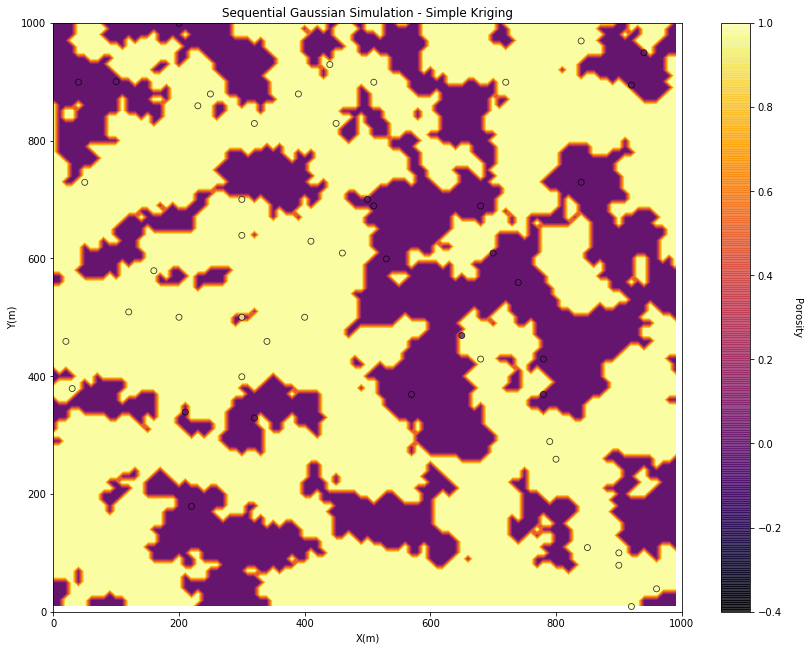

In [382]:
# Simple Kriging vs. Ordinary Kriging
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 10; nodmax = 10; radius = 400; skmean = 0
tmin = -999; tmax = 999
dummy_trend = np.zeros((10,10))

#x = [28,9999]; y = [25,9999]; v = [1,0]
#df = pd.DataFrame({'X':x,'Y':y,'Facies':v})
ncut = 2                                   # number of facies
thresh = [0,1]                             # the facies categories
gcdf = [0.4,0.6]                           # the global proportions of the categories
varios = []                                # the variogram list
varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=100,hmin1=100)) # shale indicator variogram
varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=100,hmin1=100)) # sand indicator variogram

sim_ik = sisim(df,'X','Y','Facies',ivtype=0,koption=0,ncut=2,thresh=thresh,gcdf=gcdf,trend=dummy_trend,
               tmin=tmin,tmax=tmax,zmin=0.0,zmax=1.0,ltail=1,ltpar=1,middle=1,mpar=0,utail=1,utpar=2,
               nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed = 73073,
               ndmin=ndmin,ndmax=ndmax,nodmax=nodmax,mults=1,nmult=3,noct=-1,radius=radius,ktype=0,vario=varios)

xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno
plt.subplot(221)                                          # plot the results
GSLIB.locpix_st(sim_ik,xmin,xmax,ymin,ymax,xsiz,-.4,1.0,df,'X','Y','Facies','Sequential Gaussian Simulation - Simple Kriging','X(m)','Y(m)','Porosity',cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=4.0, top=4.5, wspace=0.2, hspace=0.2)
plt.show()



In [335]:
varios[1]['cc1']

1.0

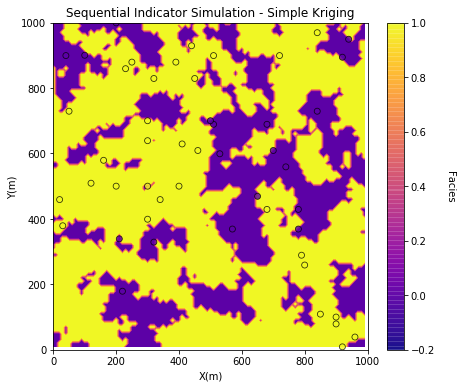

In [381]:
xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.plasma
plt.subplot(221)                                          # plot the results
GSLIB.locpix_st(sim_ik,xmin,xmax,ymin,ymax,xsiz,-.20,1.0,df,'X','Y','Facies','Sequential Indicator Simulation - Simple Kriging','X(m)','Y(m)','Facies',cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2)
plt.show()

In [84]:
threed = np.dstack(sim_ik)
threed[1,1,1]

IndexError: index 1 is out of bounds for axis 1 with size 1

We will also need some standard packages. These should have been installed with Anaconda 3.

In [20]:
import os                                                 # to set current working directory 
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames
import matplotlib.pyplot as plt                           # plotting
import geostatspy.GSLIB as GSLIB
import geostatspy.geostats as geostats

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time).  Also, in this case make sure to place the required (see above) GSLIB executables in this directory or a location identified in the environmental variable *Path*.

In [9]:
os.chdir("c:/PGE383")                                     # set the working directory

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object. We will also extra a limited sample so that the spatial samples are not too dense.  This way we can observe more of the heterogeneity from the simulation with the spatial continuity model, rather than mostly data driven heterogeneity.

In [373]:
df = pd.read_csv("sample_data_MV_biased.csv")             # read a .csv file in as a DataFrame
df.describe()                                             # summary statistics 
df = df.sample(50)                                        # extract 50 samples
df = df.reset_index()                                     # reset the record index 
df['logPerm'] = np.log(df['Perm'].values)
df.head(n=20)

,index,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI,logPerm
0,286,453,530.0,599.0,0.0,0.100367,6.621935,5523.282412,1.890388
1,225,369,510.0,899.0,1.0,0.157111,103.984254,4432.984637,4.644239
2,127,210,780.0,429.0,0.0,0.123508,23.432337,5892.392937,3.154117
3,362,574,320.0,829.0,1.0,0.180336,957.426748,4427.866875,6.864249
4,314,493,460.0,609.0,1.0,0.121072,39.207953,5210.561404,3.668880
5,195,315,740.0,559.0,0.0,0.095651,3.109239,5428.086105,1.134378
6,334,528,160.0,579.0,1.0,0.156645,71.673783,3180.807532,4.272125
7,344,541,940.0,949.0,0.0,0.102437,0.956152,4105.074357,-0.044838
8,265,421,900.0,79.0,1.0,0.149330,20.304217,4004.827681,3.010829
9,106,175,800.0,259.0,1.0,0.148592,17.303238,5383.404805,2.850894


#### Sequential Gaussian Simulation

Let's jump right to building a variety of models with simulation and visualizing the results.  We will start with a test, comparision of simulation with simple and ordinary kriging.

vrtr
[0.17631043 0.14474836 0.13138305 0.10331073 0.13243134 0.11504128
 0.13763664 0.11527452 0.11870472 0.17183007 0.15517477 0.15422044
 0.17216841 0.12365163 0.10131888 0.18033623 0.14210694 0.10273678
 0.14933042 0.13714984 0.11801194 0.15397989 0.13096539 0.14871469
 0.15447825 0.12023518 0.17182307 0.1577302  0.18460224 0.15175091
 0.10545331 0.12962503 0.14591186 0.12186281 0.12561618 0.11610737
 0.12798132 0.15442203 0.10036721 0.17946875 0.15877741]
ntr
41

 Data for SGSIM: Number of acceptable data     = 41
                 Number trimmed                = 9
                 Weighted Average              = 0.1396
                 Weighted Variance             = 0.0006
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9695
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on n

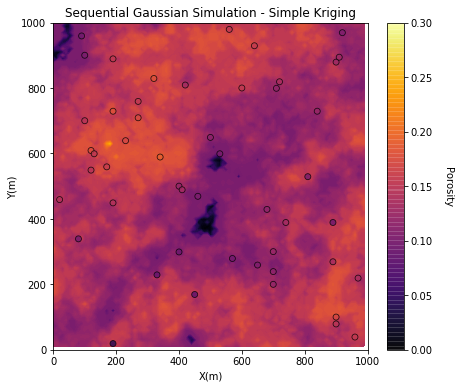

In [18]:
# Simple Kriging vs. Ordinary Kriging
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 10; radius = 400; skmean = 0
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=300,hmin1=300)
tmin = -999; tmax = 999

sim_sk = sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=0.1,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=0,colocorr=0.0,sec_map=0,vario=vario)

xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno
plt.subplot(221)                                          # plot the results
GSLIB.locpix_st(sim_sk,xmin,xmax,ymin,ymax,xsiz,0.0,0.30,df,'X','Y','Porosity','Sequential Gaussian Simulation - Simple Kriging','X(m)','Y(m)','Porosity',cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2)
plt.show()

#### Exploring Geometric Anisotropy

Le'ts look at 4 realizations of porosity all with short range isotropic variograms.


 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
                 Weighted Average              = 0.1285
                 Weighted Variance             = 0.0012
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9749
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.004 (close to 0.0?)
                                   variance = 0.9271 (close to gammabar(V,V)? approx. 1.0)


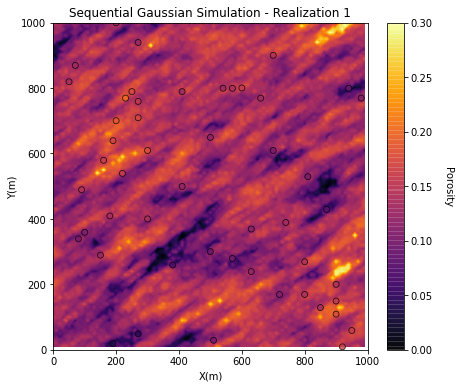

In [10]:
# Strongly Anisotropic Realization
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 10; radius = 200; ktype = 0; skmean = 0
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=200,hmin1=50)
tmin = -999; tmax = 999

sim_anis = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno
plt.subplot(221)
GSLIB.locpix_st(sim_anis,xmin,xmax,ymin,ymax,xsiz,0.0,0.30,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 1','X(m)','Y(m)','Porosity',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2)
plt.show()

#### Exploring Multiple Realizations

Let's look at 4 realizations of porosity all with short range isotropic variograms.


 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
                 Weighted Average              = 0.1285
                 Weighted Variance             = 0.0012
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9749
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0257 (close to 0.0?)
                                   variance = 0.9964 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
        

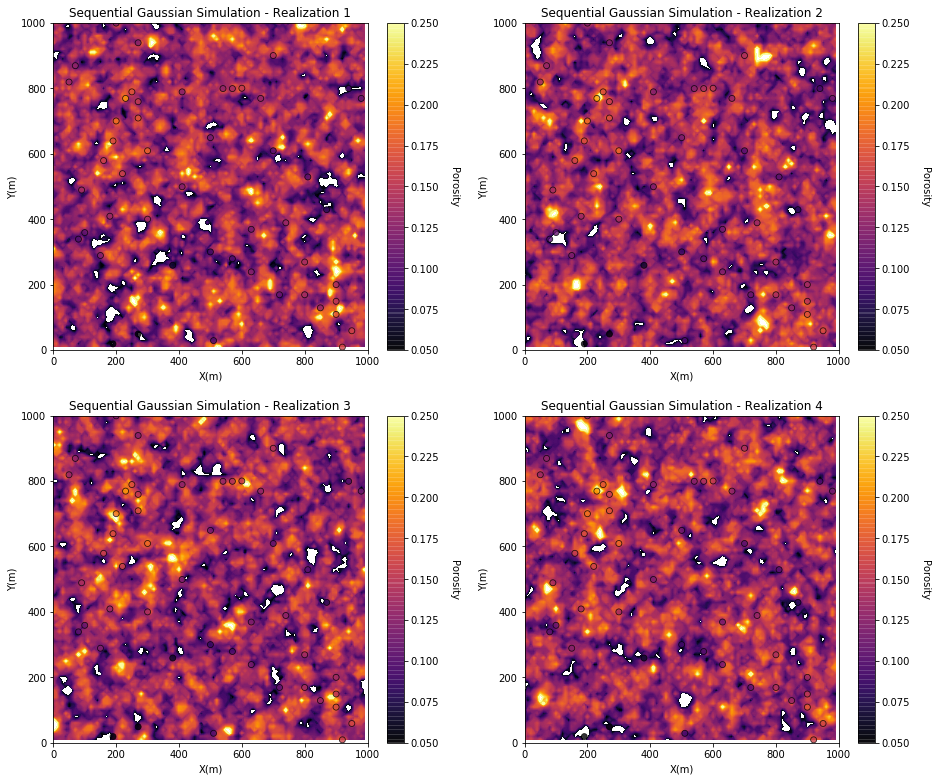

In [11]:
# Demonstration of Multiple Realizations - Short Continuity
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 20; radius = 50; ktype = 0; skmean = 0
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=50,hmin1=50)
tmin = -999; tmax = 999

sim = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

sim2 = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73072,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

sim3 = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73071,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

sim4 = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73070,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno
plt.subplot(221)
GSLIB.locpix_st(sim,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 1','X(m)','Y(m)','Porosity',cmap)

plt.subplot(222)
GSLIB.locpix_st(sim2,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 2','X(m)','Y(m)','Porosity',cmap)

plt.subplot(223)
GSLIB.locpix_st(sim3,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 3','X(m)','Y(m)','Porosity',cmap)

plt.subplot(224)
GSLIB.locpix_st(sim4,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 4','X(m)','Y(m)','Porosity',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2)
plt.show()

Let's look at 4 realizations of porosity all with long range isotropic variograms.


 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
                 Weighted Average              = 0.1246
                 Weighted Variance             = 0.0011
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9749
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0238 (close to 0.0?)
                                   variance = 0.778 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
        

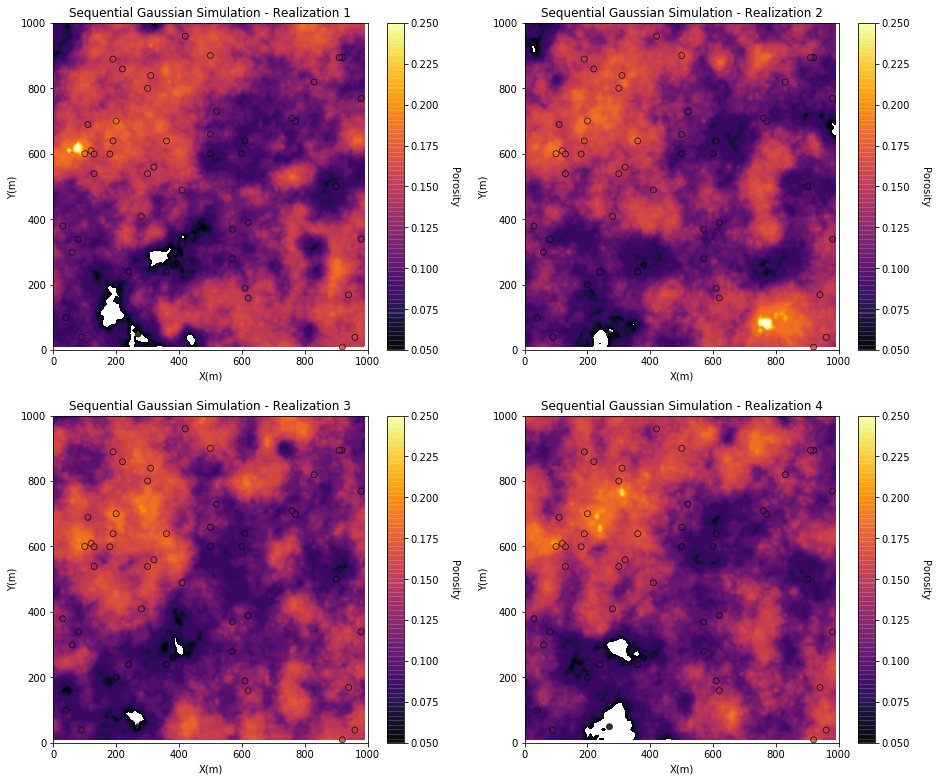

In [21]:
# Demonstration of Multiple Realizations - Long Continuity
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 20; radius = 100; ktype = 0; skmean = 0
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=500,hmin1=500)
tmin = -999; tmax = 999

sim = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

sim2 = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73072,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

sim3 = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73071,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

sim4 = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73070,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno
plt.subplot(221)
GSLIB.locpix_st(sim,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 1','X(m)','Y(m)','Porosity',cmap)

plt.subplot(222)
GSLIB.locpix_st(sim2,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 2','X(m)','Y(m)','Porosity',cmap)

plt.subplot(223)
GSLIB.locpix_st(sim3,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 3','X(m)','Y(m)','Porosity',cmap)

plt.subplot(224)
GSLIB.locpix_st(sim4,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 4','X(m)','Y(m)','Porosity',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2)
plt.show()

#### Sequential Gaussian Simulation - Collocated Cokriging

Now let's demonstrate collocated cokriging.  We first calculate a realization of porosity and then collocated cokriging realization of permeability constrained to the porosity realizations.

vrtr
[0.17631043 0.14474836 0.13138305 0.10331073 0.13243134 0.11504128
 0.13763664 0.11527452 0.11870472 0.17183007 0.04112152 0.15517477
 0.15422044 0.17216841 0.12365163 0.10131888 0.18033623 0.14210694
 0.09708466 0.10273678 0.0842506  0.14933042 0.13714984 0.11801194
 0.15397989 0.13096539 0.14871469 0.15447825 0.09260126 0.12023518
 0.17182307 0.1577302  0.07936374 0.18460224 0.15175091 0.10545331
 0.12962503 0.14591186 0.12186281 0.12561618 0.09406236 0.08922711
 0.11610737 0.12798132 0.15442203 0.10036721 0.17946875 0.15877741
 0.09057956 0.09929825]
ntr
50

 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
                 Weighted Average              = 0.1298
                 Weighted Variance             = 0.0009
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9749
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on n

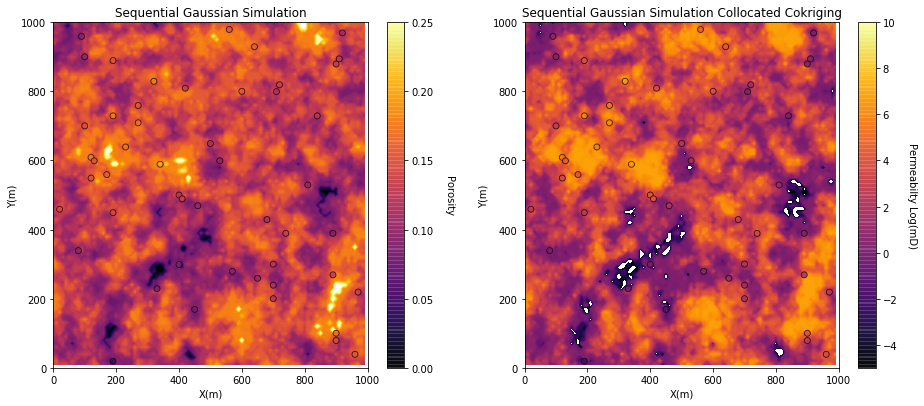

In [20]:
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 20; radius = 100; ktype = 0; skmean = 0
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=100,hmin1=100)
tmin = -99999; tmax = 999

trend = np.zeros((ny,nx))
for iy in range(0,ny):
    for ix in range(0,nx):
        trend[iy,ix] = -1*(iy-ny/2)/(ny)*0.03+.127
#trend = np.array([[1.0,2.0,3.0],[4.0,5.0,6.0],[7.0,8.0,9.0]]) 
    
sim_por = sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=0,colocorr=0.0,sec_map=trend,vario=vario)

sim_perm = sgsim(df,'X','Y','Perm',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=1000.0,ltail=1,ltpar=0.0,utail=1,utpar=1000.0,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73075,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=4,colocorr=0.9,sec_map=sim_por,vario=vario)

xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno
plt.subplot(121)
GSLIB.locpix_st(sim_por,xmin,xmax,ymin,ymax,xsiz,0.0,0.250,df,'X','Y','Porosity','Sequential Gaussian Simulation','X(m)','Y(m)','Porosity',cmap)
sim_log_perm = np.log(sim_perm.clip(0.0001,1200))
plt.subplot(122)
GSLIB.locpix_st(sim_log_perm,xmin,xmax,ymin,ymax,xsiz,-5.0,10,df,'X','Y','logPerm','Sequential Gaussian Simulation Collocated Cokriging','X(m)','Y(m)','Permeabilty Log(mD)',cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()


 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
                 Weighted Average              = 116.1961
                 Weighted Variance             = 104458.9401
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9749
 Secondary Data: Number of data             = 10000
                 Equal Weighted Average     = 0.1275
                 Equal Weighted Variance    = 0.0013
 Transforming Secondary Data with
 variance reduction of 1.0
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 

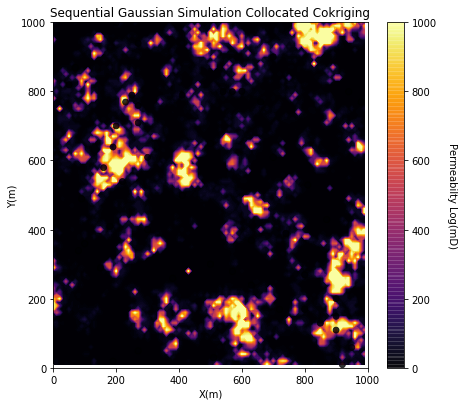

In [13]:
sim_perm = geostats.sgsim(df,'X','Y','Perm',wcol=-1,scol=-1,tmin=tmin,tmax=999999,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=1000.0,ltail=1,ltpar=0.0,utail=1,utpar=1000.0,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73075,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=4,colocorr=0.9,sec_map=sim_por,vario=vario)

plt.subplot(122)
GSLIB.locpix_st(sim_perm,xmin,xmax,ymin,ymax,xsiz,0.0,1000,df,'X','Y','logPerm','Sequential Gaussian Simulation Collocated Cokriging','X(m)','Y(m)','Permeabilty Log(mD)',cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

#### Comments

This was a basic demonstration of spatial simulation. I know the simulation program is rough and the code needs some clean up, but we are getting to the point where we have a function package for Geostatistics in Python.  

Much more could be done, I have other demonstrations on the basics of working with DataFrames, ndarrays, univariate statistics, plotting data, declustering, data transformations and many other workflows available at https://github.com/GeostatsGuy/PythonNumericalDemos and https://github.com/GeostatsGuy/GeostatsPy. 
  
I hope this was helpful,

*Michael*

#### The Author:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)
